
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [1]:
import os
import pandas as pd
from zipfile import ZipFile
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import statsmodels
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import matplotlib.gridspec as gridspec
from PIL import Image
import urllib.request as url
import io
import math
import datetime as dt
%matplotlib inline

In [2]:
# download data and move into PUIDATA

In [3]:
!wget https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD -O energy.csv
!wget https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip -O mn_mappluto_18v1.zip

--2018-11-29 13:38:27--  https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘energy.csv’

energy.csv              [       <=>          ]   4.23M  3.28MB/s    in 1.3s    

Last-modified header invalid -- time-stamp ignored.
2018-11-29 13:38:29 (3.28 MB/s) - ‘energy.csv’ saved [4433512]

--2018-11-29 13:38:29--  https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip
Resolving www1.nyc.gov (www1.nyc.gov)... 104.112.26.93, 2600:1408:24:48b::1500, 2600:1408:24:4a0::1500
Connecting to www1.nyc.gov (www1.nyc.gov)|104.112.26.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11582182 (11M) [application/zip]
Saving to: ‘mn_map

In [4]:
!mv energy.csv $PUIDATA
!mv mn_mappluto_18v1.zip $PUIDATA

In [5]:
zip_result = ZipFile(os.getenv("PUIDATA") + '/' + 'mn_mappluto_18v1.zip','r')
zip_result.extractall(os.getenv("PUIDATA") + '/' + 'hw10')

In [6]:
# read data

In [52]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + "/energy.csv")

bsize = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/hw10/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

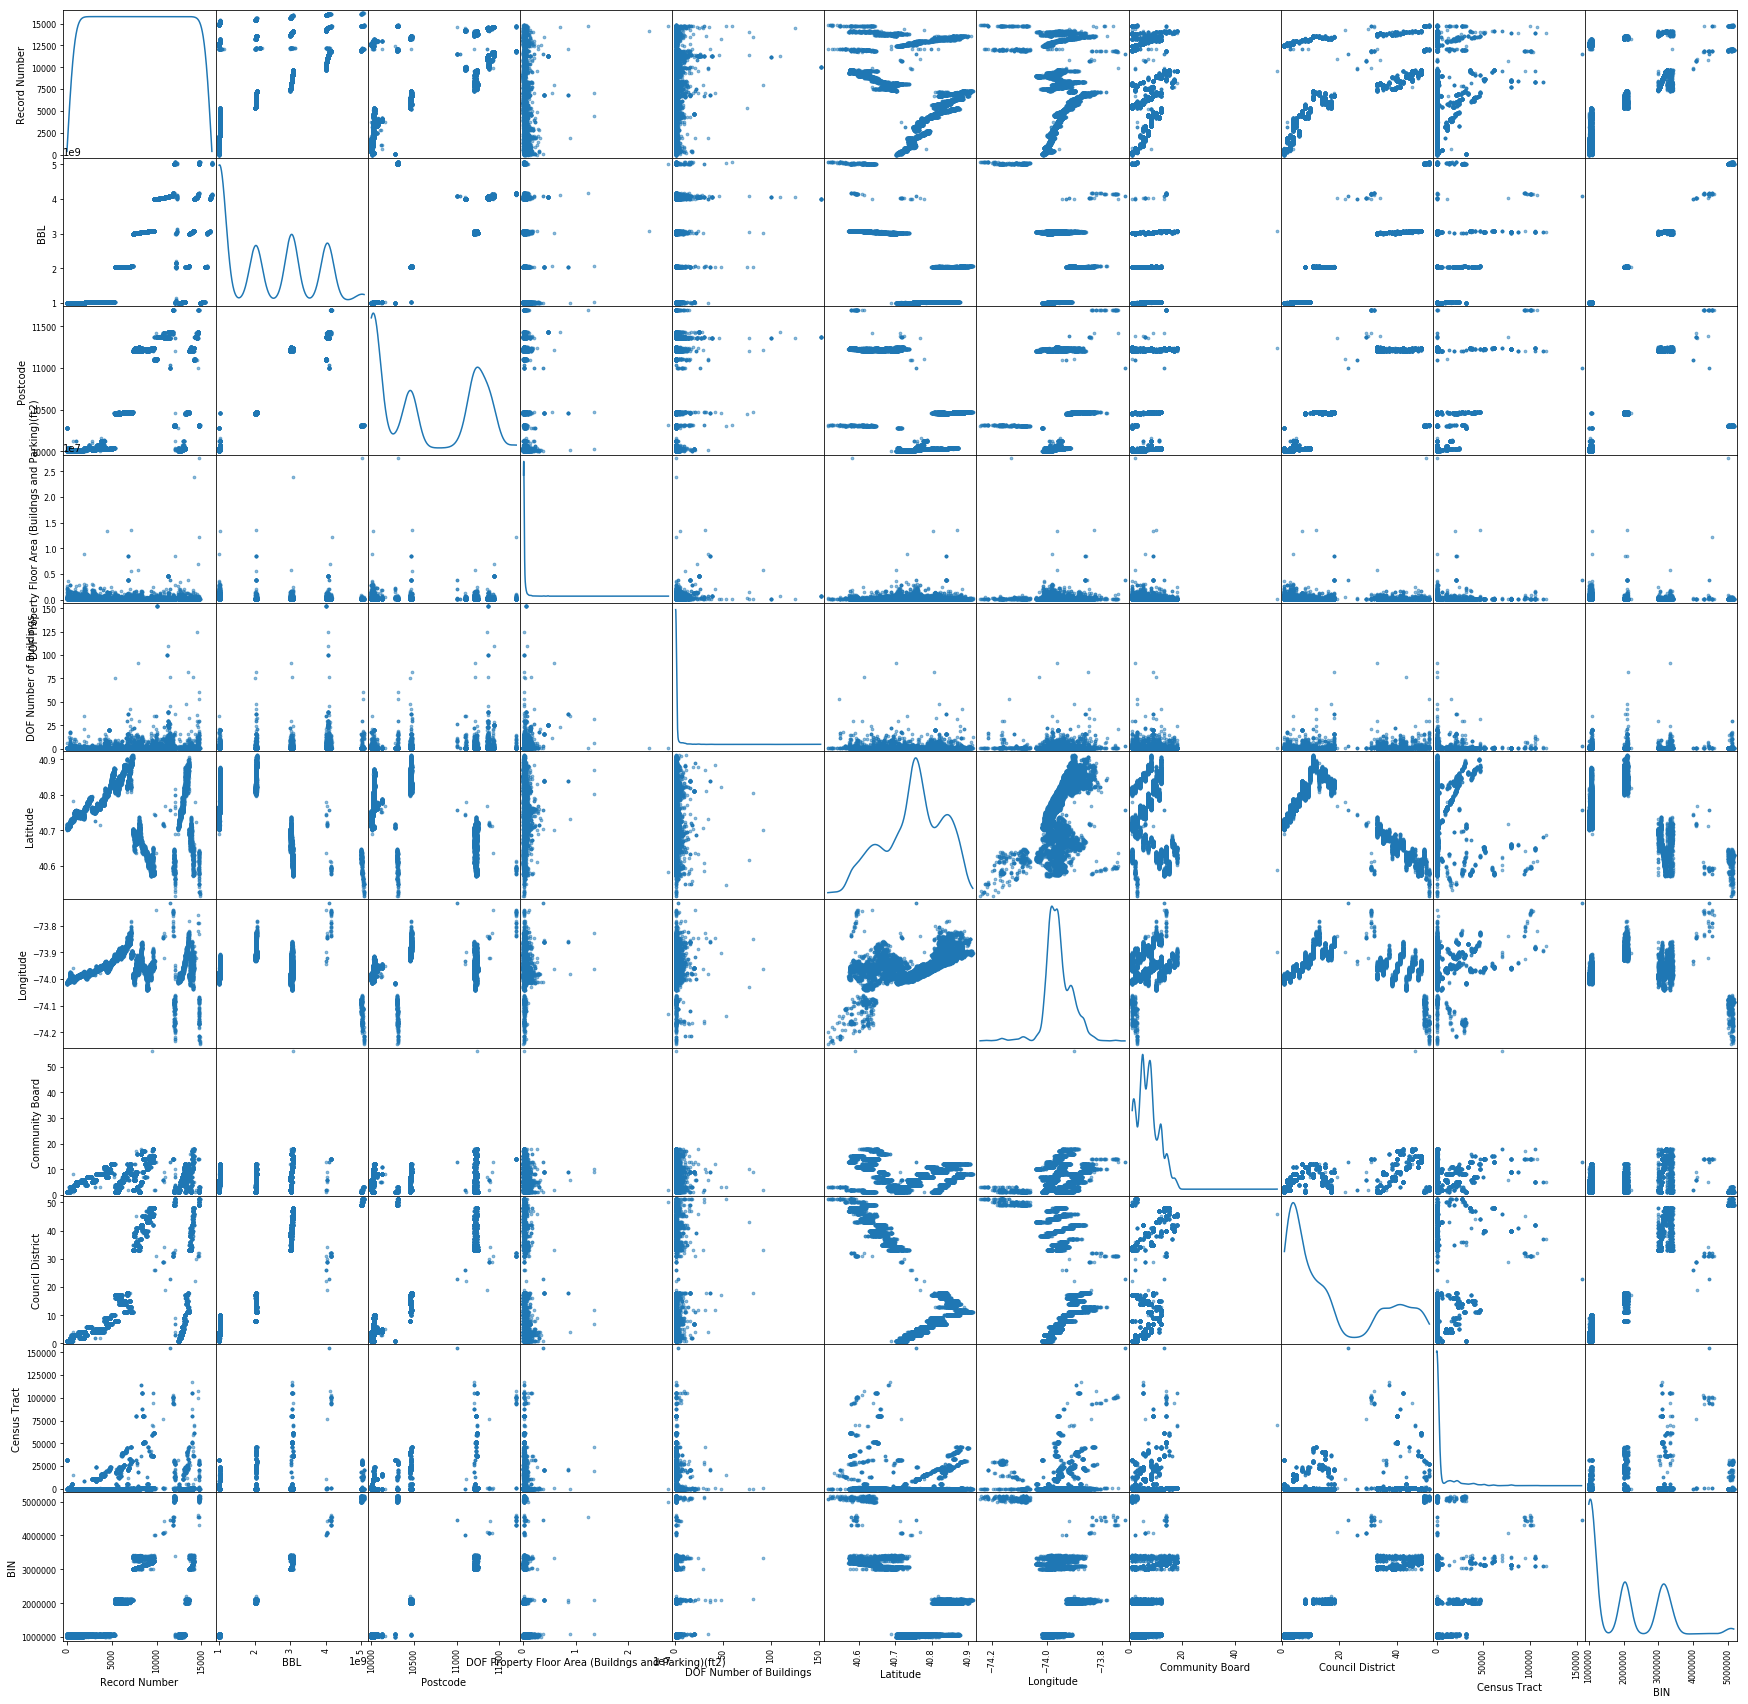

In [8]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(30, 30), diagonal='kde')

Figure 1: The diagonal of this plot is the Kernel Density Estimation of each variable, and the rest plot is the scatter plot of variables against each other. This plot gives us a brief preliminary relationshio between each pair of variables.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [53]:
nrg = nrg[['BBL', 'Reported Property Floor Area (Building(s)) (ft²)', 'Site EUI(kBtu/ft2)']]
bsize = bsize[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL', 'geometry']]

**Site EUI**: The Site Energy Use Intensity (EUI), as calculated by Portfolio Manager, at the property site. This
equals the amount of energy consumed at the site in thousand British thermal units (kBtus) per gross square
foot (kBtu/ft2
) of the property. Site EUI values are the result of self-reported entries.

In [10]:
nrg.head()

,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2)
0,1.000410e+09,918919,NaN
1,4.021460e+09,NaN,NaN
2,2.027620e+09,64200,NaN
3,1.006700e+09,NaN,NaN
4,2.048300e+09,50000,NaN


In [11]:
#leave
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


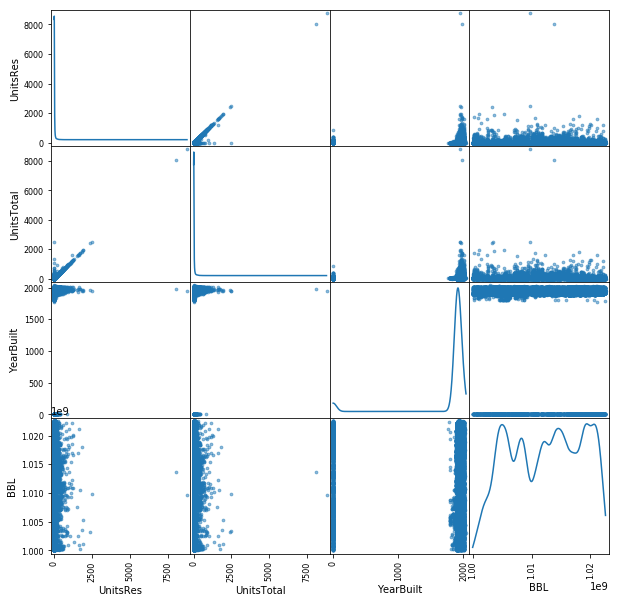

In [12]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: The diagonal of this plot is the Kernel Density Estimation of each variable, and the rest plot is the scatter plot of variables against each other. This plot gives us a brief preliminary relationshio between each pair of variables.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [13]:
# convert values to numeric

In [54]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')
bsize['BBL'] = pd.to_numeric(bsize['BBL'], errors='coerce')

In [15]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [16]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [17]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [18]:
nrg.head()

,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2)
0,1.000410e+09,918919.0,NaN
1,4.021460e+09,NaN,NaN
2,2.027620e+09,64200.0,NaN
3,1.006700e+09,NaN,NaN
4,2.048300e+09,50000.0,NaN


In [19]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [55]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg, left_on='BBL', right_on='BBL')
bblnrgdata = bsize.merge(nrg, left_on='BBL', right_on='BBL')
del bblnrgdata['geometry']

In [21]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2)
0,50,50,1914,1.007238e+09,95844.0,68.7
1,29,32,1928,1.013850e+09,206989.0,87.4
2,72,72,1923,1.021740e+09,52920.0,140.4
3,107,108,1931,1.008830e+09,98359.0,96.5
4,134,138,1910,1.008570e+09,154000.0,36.4


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

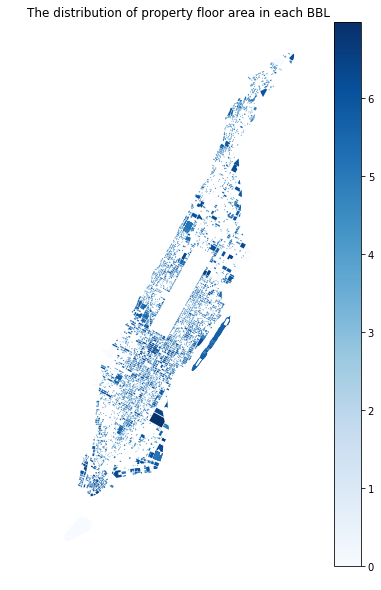

In [56]:
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'] + 1.)
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'] + 1.)
bblnrgdataGPD.to_crs(epsg=2263).plot(column='logarea', legend=True, figsize=(10,10), cmap='Blues')
plt.axis('off')
plt.title('The distribution of property floor area in each BBL')
plt.show()

Figuer 3. This plot shows the distribution of property floor area in each BBL

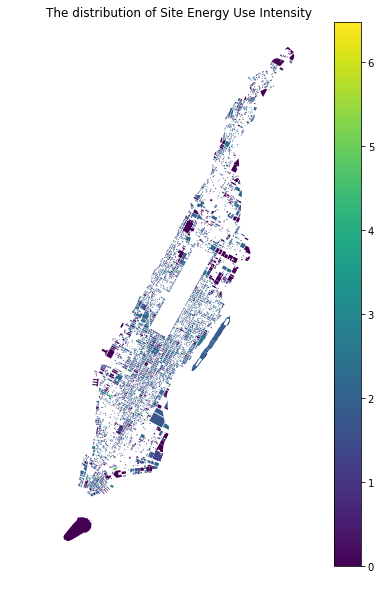

In [23]:
bblnrgdataGPD.to_crs(epsg=2263).plot(column='lognrg', legend=True, figsize=(10,10))
plt.axis('off')
plt.title('The distribution of Site Energy Use Intensity')
plt.show()

Figure 4: This plot shows the  distribution of Site Energy Use Intensity

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [24]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2)
0,50,50,1914,1.007238e+09,95844.0,68.7
1,29,32,1928,1.013850e+09,206989.0,87.4
2,72,72,1923,1.021740e+09,52920.0,140.4
3,107,108,1931,1.008830e+09,98359.0,96.5
4,134,138,1910,1.008570e+09,154000.0,36.4


minimum building energy value 0.0
maximum building energy value 350145188000.0


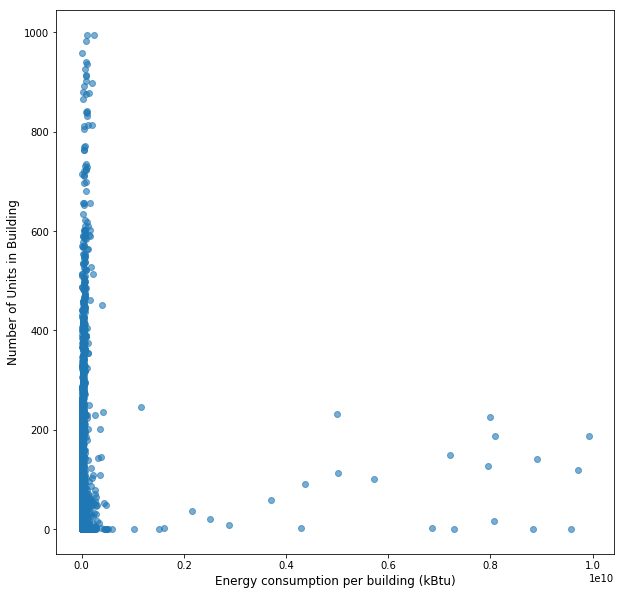

In [57]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
bblnrgdata_cut = bblnrgdata[(bblnrgdata['nrg'] != 0) & (bblnrgdata['UnitsTotal'] < 1000) & (bblnrgdata['nrg']<1e10) & (bblnrgdata['nrg']>1)]
print('minimum building energy value', bblnrgdata['nrg'].min())
print('maximum building energy value', bblnrgdata['nrg'].max())
plt.figure(figsize=(10,10))
plt.xlabel('Energy consumption per building (kBtu)', fontsize=12)
plt.ylabel('Number of Units in Building', fontsize=12)
plt.scatter(bblnrgdata_cut['nrg'], bblnrgdata_cut['UnitsTotal'], alpha=0.6)

Figure 4: This polt shows the distribution of Energy consumption per building (kBtu) and Number of Units in Building.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

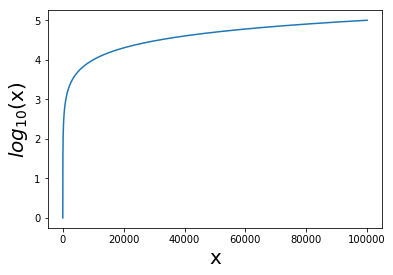

In [26]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [27]:
bblnrgdata.head(2)

,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2),nrg
0,50,50,1914,1.007238e+09,95844.0,68.7,6584482.8
1,29,32,1928,1.013850e+09,206989.0,87.4,18090838.6


Text(0.5,1,'Units total vs NRG')

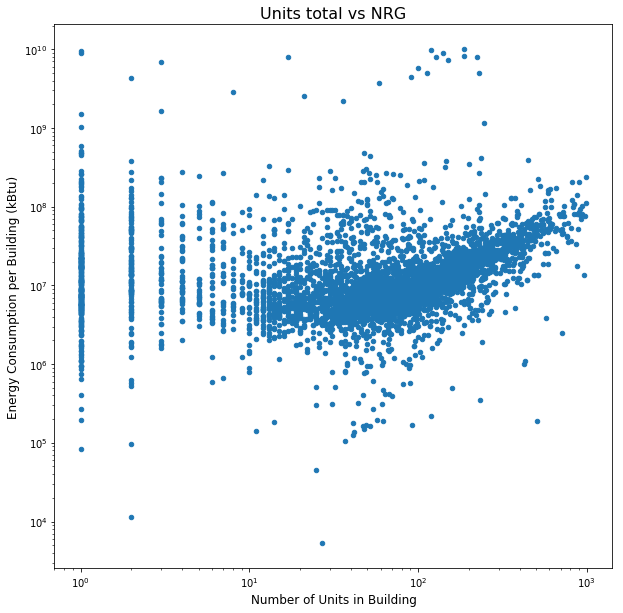

In [28]:

bblnrgdata_cut.plot(kind='scatter', y='nrg', x='UnitsTotal', loglog=True, figsize=(10,10))
plt.ylabel('Energy Consumption per Building (kBtu)', fontsize=12)
plt.xlabel('Number of Units in Building', fontsize=12)
plt.title('Units total vs NRG', fontsize=16)

Figure 6 : This plot shows the distribution of log(nrg) and log(UnitsTotal). The x axis is Number of Units in Building, and the y axis is Energy Consumption per Building (kBtu). There is a rough tendency that the value of Number of Units in Building and the value of Energy Consumption per Building is positively related to each other.

Text(0.5,1,'NRG VS Units total')

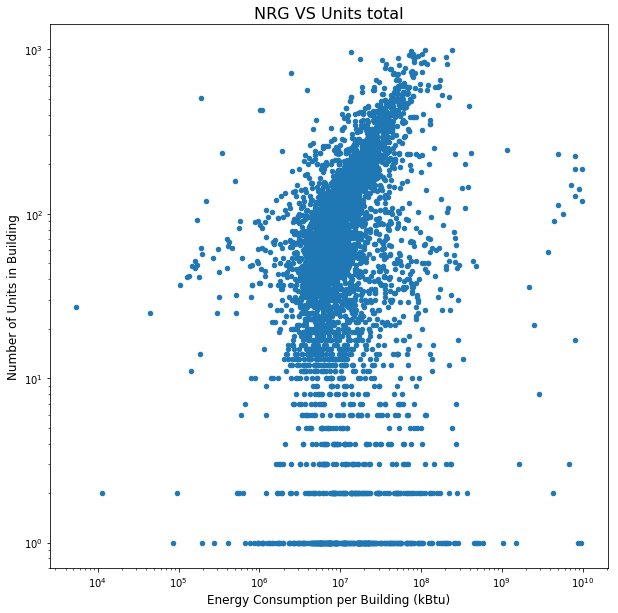

In [29]:
bblnrgdata_cut.plot(kind='scatter', x='nrg', y='UnitsTotal', loglog=True, figsize=(10,10))
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=12)
plt.ylabel('Number of Units in Building', fontsize=12)
plt.title('NRG VS Units total', fontsize=16)

Figure 7 :  This plot shows the distribution of log(nrg) and log(UnitsTotal). The y axis is Number of Units in Building, and the x axis is Energy Consumption per Building (kBtu).

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


                            OLS Regression Results                            
Dep. Variable:                log_nrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     89.92
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           3.74e-21
Time:                        13:56:45   Log-Likelihood:                -3394.2
No. Observations:                4984   AIC:                             6792.
Df Residuals:                    4982   BIC:                             6805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.8672      0.020    349.

Text(0.5,1,'Units total VS NRG')

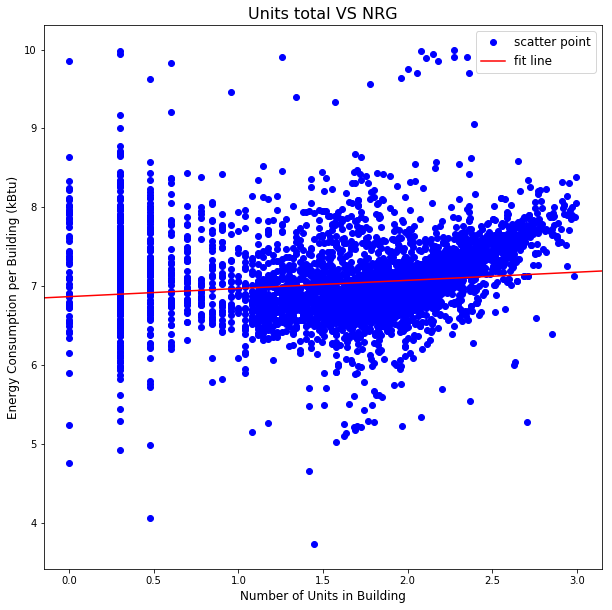

In [58]:
bblnrgdata_cut['log_nrg'] = np.log10(bblnrgdata_cut['nrg'] + 1.)
bblnrgdata_cut['log_UnitsTotal'] = np.log10(bblnrgdata_cut['UnitsTotal'] + 1.)
mod1 = smf.ols(formula='log_nrg ~ log_UnitsTotal', data=bblnrgdata_cut).fit()
print(mod1.summary())
figure, ax = plt.subplots(figsize=(10,10))
# plt.figure()
# plt.figure(figsize=(20,10))
plt.plot(bblnrgdata_cut['log_UnitsTotal'], bblnrgdata_cut['log_nrg'], 'bo',label='scatter point')

ax = abline_plot(model_results=mod1, ax=ax, color='red',label='fit line')
plt.legend(fontsize=12)
plt.ylabel('Energy Consumption per Building (kBtu)', fontsize=12)
plt.xlabel('Number of Units in Building', fontsize=12)
plt.title('Units total VS NRG', fontsize=16)

Figure 8. This plot shows the distribution of log(nrg) and log(UnitsTotal). The x axis is Number of Units in Building, and the y axis is Energy Consumption per Building (kBtu). The red line is the fit line. In this model, the adjusted R-square is 0.018 and the log-likelihood is -3394.2.

### Energy against Units

                            OLS Regression Results                            
Dep. Variable:         log_UnitsTotal   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     89.92
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           3.74e-21
Time:                        13:39:26   Log-Likelihood:                -4657.7
No. Observations:                4984   AIC:                             9319.
Df Residuals:                    4982   BIC:                             9332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4822      0.128      3.776      0.0

Text(0.5,1,'NRG VS Units total')

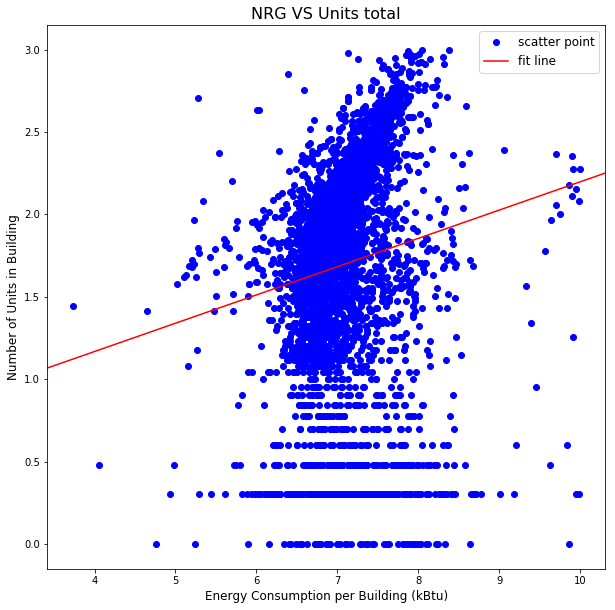

In [31]:
mod2 = smf.ols(formula='log_UnitsTotal ~ log_nrg', data=bblnrgdata_cut).fit()
print(mod2.summary())
figure, ax = plt.subplots(figsize=(10,10))
# plt.figure()
# plt.figure(figsize=(20,10))
plt.plot(bblnrgdata_cut['log_nrg'], bblnrgdata_cut['log_UnitsTotal'], 'bo',label='scatter point')

ax = abline_plot(model_results=mod2, ax=ax, color='red',label='fit line')
plt.legend(fontsize=12)
plt.xlabel('Energy Consumption per Building (kBtu)', fontsize=12)
plt.ylabel('Number of Units in Building', fontsize=12)
plt.title('NRG VS Units total', fontsize=16)


Figure 9. This plot shows the distribution of log(nrg) and log(UnitsTotal). The y axis is Number of Units in Building, and the x axis is Energy Consumption per Building (kBtu). The red line is the fit line. In this model, the adjusted R-square is 0.018 and the log-likelihood is -4657.7.

In the last two function, although they have the same value of adjusted R-square, but the first one has larger Log-likelihood value. In the further regressrion, I am going to use Number of Units in Building as independent variable and use Energy consumption per Building as dependent variable.

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                            OLS Regression Results                            
Dep. Variable:                log_nrg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     483.0
Date:                Thu, 29 Nov 2018   Prob (F-statistic):          1.94e-192
Time:                        13:56:58   Log-Likelihood:                -2997.0
No. Observations:                4984   AIC:                             6000.
Df Residuals:                    4981   BIC:                             6020.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           7.4597      0.027    2

Text(0.5,0,'Number of Units in Building')

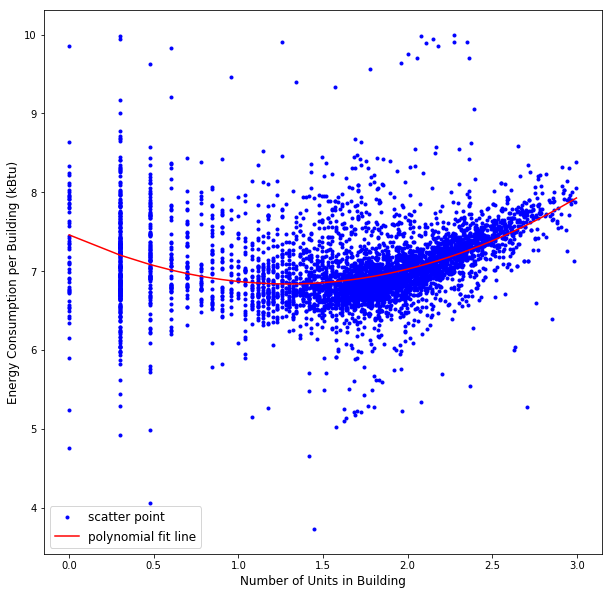

In [59]:

bblnrgdata_cut['square_log_unit'] = bblnrgdata_cut['log_UnitsTotal'] ** 2
mod_log = smf.ols(formula='log_nrg ~ log_UnitsTotal + square_log_unit', data = bblnrgdata_cut).fit()
print(mod_log.summary())
# create polynomial
bblnrgdata_cut['predict'] = mod_log.predict()
figure, ax = plt.subplots(figsize=(10,10))
# plt.figure()
# plt.figure(figsize=(20,10))
df = bblnrgdata_cut.sort_values(by=['log_UnitsTotal'])
plt.plot(bblnrgdata_cut['log_UnitsTotal'], bblnrgdata_cut['log_nrg'], 'b.',label='scatter point')

plt.plot(df['log_UnitsTotal' ], df['predict'], 'r', label='polynomial fit line')
# ax = abline_plot(model_results=mod, ax=ax, color='red',label='fit line')

plt.legend(fontsize=12)
plt.ylabel('Energy Consumption per Building (kBtu)', fontsize=12)
plt.xlabel('Number of Units in Building', fontsize=12)

Figure 9. This plot shows the distribution of log(nrg) and log(UnitsTotal). The x axis is Number of Units in Building, and the y axis is Energy Consumption per Building (kBtu). This model is a polynomial model, the independent variable is the suqare of log(UnitsTotal) and log(UnitsTotal). The red line is the polynomial fit line. In this model, the adjusted R-square is 0.162 and the log-likelihood is -2997.0.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [33]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.zeros(len(data)) + 1
    else:
        pass
    chi2 = (((model.predict() - data) ** 2) / (errors ** 2)).sum()
    return chi2

In [34]:
chi2_energy = chi2(bblnrgdata_cut['log_nrg'], mod_log)
chi2_energy

971.43366604794846

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [35]:
bblnrgdataCut = bblnrgdata_cut

In [36]:
bblnrgdataCut.head(2)

,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2),nrg,log_nrg,log_UnitsTotal,square_log_unit,predict
0,50,50,1914,1.007238e+09,95844.0,68.7,6584482.8,6.818522,1.707570,2.915796,6.902655
1,29,32,1928,1.013850e+09,206989.0,87.4,18090838.6,7.257459,1.518514,2.305885,6.857010


In [68]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
# but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well

#error of total energy
# as error_bblnrgdata_cut['Reported Property Floor Area (Building(s)) (ft²) = 
# np.sqrt(bblnrgdata_cut['Reported Property Floor Area (Building(s)) (ft²))

errorsnrg = np.sqrt((bblnrgdata_cut['Reported Property Floor Area (Building(s)) (ft²)']) + \
                    (bblnrgdata_cut['Site EUI(kBtu/ft2)']))
#error of log energy
error_log_nrg = errorsnrg / (bblnrgdataCut['nrg'] * np.log(10))

#error of log unit
error_log_unit = (np.sqrt(bblnrgdataCut['UnitsTotal'])) / (bblnrgdataCut['UnitsTotal'] * np.log(10))

#add to dataframe
bblnrgdataCut['errorsunits'] = error_log_unit
bblnrgdataCut['errorsnrg'] = error_log_nrg

In [90]:
# to avoid the insane small values of error
# as nqr = eui * unit
# log(nqr) = log(eui * unit) = log(eui) + log(unit)
bblnrgdataCut['errors_log_size'] = (np.sqrt(bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)']))\
                                / (bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'] * np.log(10))
bblnrgdataCut['errors_log_eui'] = (np.sqrt(bblnrgdataCut['Site EUI(kBtu/ft2)']))\
                                / (bblnrgdataCut['Site EUI(kBtu/ft2)'] * np.log(10))
bblnrgdataCut['errorsnrg'] = np.sqrt((bblnrgdataCut['errors_log_size'] ** 2) + (bblnrgdataCut['errors_log_eui'] **2)
                             + 2 * np.sqrt(bblnrgdataCut['errors_log_size'] * bblnrgdataCut['errors_log_eui']))

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2),nrg,log_nrg,log_UnitsTotal,square_log_unit,predict,errorsnrg,errorsunits,errors_log_size,errors_log_eui
3313,27,27,1909,1.019900e+09,53440.0,0.1,5344.0,3.727948,1.447158,2.094266,6.846728,1.409862,0.08358,0.001879,1.37336


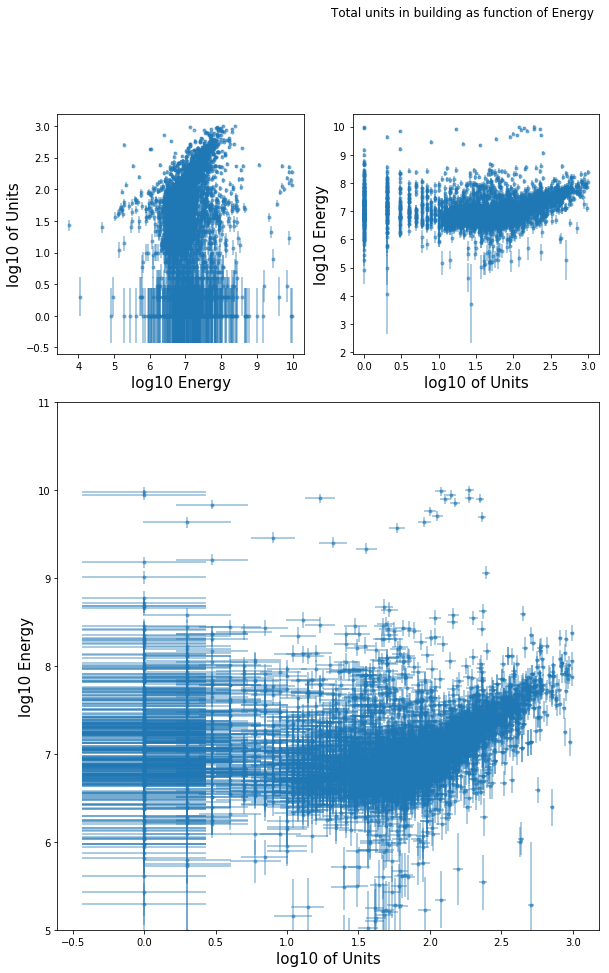

In [79]:
#I could also include errors for number of units
fig2 = plt.figure(figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [39]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdataCut) - len(mod1.params)
print ("degrees of freedom:" , dof)

degrees of freedom: 4982


In [40]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(bblnrgdataCut.log_nrg, mod1) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(bblnrgdataCut.log_nrg, mod1, 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(bblnrgdataCut.log_nrg, mod1, 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 0.23
Energy vs Units chi square per DOF w independent variable error only: 304207181870479070724096.00
Energy vs Units chi square per DOF : 116.51


In [41]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(bblnrgdataCut.log_UnitsTotal, mod2) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(bblnrgdataCut.log_UnitsTotal, mod2, 
            errors = bblnrgdataCut.errorsunits) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(bblnrgdataCut.log_UnitsTotal, mod2, 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 0.38
Units vs Energy chi square per DOF w independent variable error only: 209.82
Units vs Energy chi square per DOF : 209.82


### Compare the models using the  chi square:
According to the Chi-Square calculation result, model 1 has a smaller value of chi-square, thus, model 1 is better than model 2. This result is same as the result of comparing the Log-likelihood value.

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Text(0.5,1,'The influence of data points in model 1')

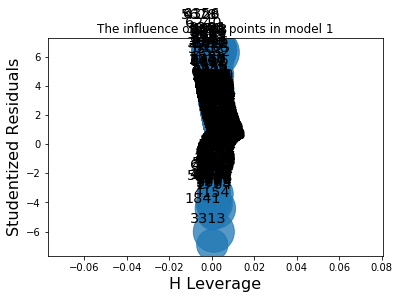

In [42]:
# fig = plt.figure(figsize=(15,15))
statsmodels.graphics.regressionplots.influence_plot(mod1, figsize=(30,30))
plt.title('The influence of data points in model 1', fontsize=12)

Figure 10: This plot shows the influence of model 1 (Units amount vs energy consumption)

Text(0.5,1,'The influence of data points in model 2')

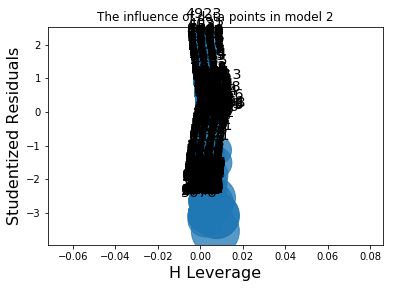

In [43]:
statsmodels.graphics.regressionplots.influence_plot(mod2, figsize=(30,30))
plt.title('The influence of data points in model 2', fontsize=12)

Figure 10: This plot shows the influence of model 2 (energy consumption vs Units amount)

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


In [44]:
print(mod1.summary())
print(mod_log.summary())

                            OLS Regression Results                            
Dep. Variable:                log_nrg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     89.92
Date:                Thu, 29 Nov 2018   Prob (F-statistic):           3.74e-21
Time:                        13:39:46   Log-Likelihood:                -3394.2
No. Observations:                4984   AIC:                             6792.
Df Residuals:                    4982   BIC:                             6805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          6.8672      0.020    349.

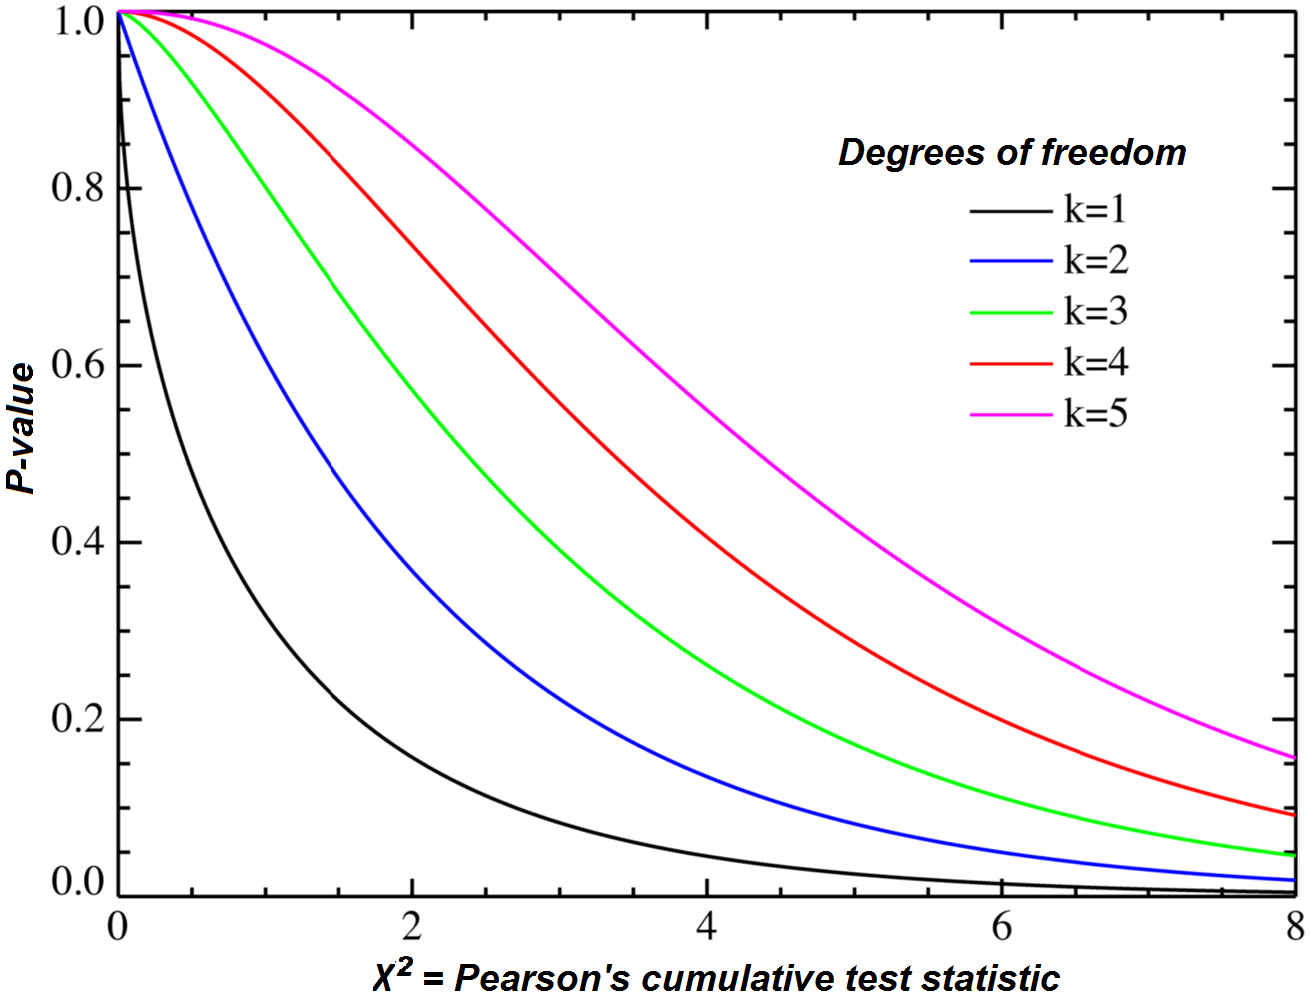

In [45]:


fd = url.urlopen('https://upload.wikimedia.org/wikipedia/commons/8/8e/Chi-square_distributionCDF-English.png')
image_file = io.BytesIO(fd.read())
Image.open(image_file)

In [46]:
LR = -2 * (-3394.2 + 2997.0 )
print(LR)

794.3999999999996


LR = *794.3999999999996*, from the above picture, when *k = 1*, significant = 0.05, the value of chi-square is smaller than 4. Therefore, we can reject the null hypothesis and conclude that those two models in this case is different.

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

logL=∑(−(a⋅mi+b)Δm+xi⋅log(a⋅mi+b)+xilog(Δm)−log(xi!)) 

In [48]:
slope = [0.082, 0.125]
interception = [6.829, 6.906]
def log_likelihood(a,b):
    for i in a:
        for j in b:
            bblnrgdataCut['fake_predict'] = i * bblnrgdataCut['log_UnitsTotal'] + j
            sigma = (bblnrgdataCut['fake_predict'].std()) ** 2
#             for k in range(len(bblnrgdataCut)):
            bblnrgdataCut['residual'] = ((bblnrgdataCut['log_nrg'] - bblnrgdataCut['fake_predict']) ** 2)
            log_likelihood = (-len(bblnrgdataCut) / 2) * math.log(2 * math.pi * sigma) - ((1 / (2 * sigma)) * bblnrgdataCut['residual'].sum())
            print(i, j)
#             print(math.exp(bblnrgdataCut['residual'].sum() / (-2 * sigma)))
            print(log_likelihood)
#             print(bblnrgdataCut['residual'].sum())
#             print((1 / (sigma * np.sqrt(2 * math.pi))) ** len(bblnrgdataCut))

In [49]:
bblnrgdataCut.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Reported Property Floor Area (Building(s)) (ft²),Site EUI(kBtu/ft2),nrg,log_nrg,log_UnitsTotal,square_log_unit,predict,errorsnrg,errorsunits
0,50,50,1914,1.007238e+09,95844.0,68.7,6584482.8,6.818522,1.707570,2.915796,6.902655,7.960491e-09,0.061419
1,29,32,1928,1.013850e+09,206989.0,87.4,18090838.6,7.257459,1.518514,2.305885,6.857010,2.568394e-09,0.076773
2,72,72,1923,1.021740e+09,52920.0,140.4,7429968.0,6.870987,1.863323,3.471972,6.960336,4.939570e-09,0.051182
3,107,108,1931,1.008830e+09,98359.0,96.5,9491643.5,6.977341,2.037426,4.151107,7.046281,4.660067e-09,0.041790
4,134,138,1910,1.008570e+09,154000.0,36.4,5605600.0,6.748622,2.143015,4.592512,7.109444,1.284289e-08,0.036970


In [95]:
## for convience, I re-defined the func
def chi2(a, b, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.zeros(len(bblnrgdataCut)) + 1
    else:
        pass
    bblnrgdataCut['predict'] = a * bblnrgdataCut['log_UnitsTotal'] + b
    chi2 = (((bblnrgdataCut['predict'] - bblnrgdataCut['log_nrg']) ** 2) / (errors ** 2)).sum()
    return chi2

In [96]:
resids_noerror = []
resids = []
for i in np.arange(-50,50,0.5):
    for j in np.arange(-100,100,1):
        resids_noerror.append(chi2(i, j) / dof)
        resids.append(chi2(i, j, errors=bblnrgdataCut['errorsnrg']) / dof)
        print(i ,j)


-50.0 -100
-50.0 -99
-50.0 -98
-50.0 -97
-50.0 -96
-50.0 -95
-50.0 -94
-50.0 -93
-50.0 -92
-50.0 -91
-50.0 -90
-50.0 -89
-50.0 -88
-50.0 -87
-50.0 -86
-50.0 -85
-50.0 -84
-50.0 -83
-50.0 -82
-50.0 -81
-50.0 -80
-50.0 -79
-50.0 -78
-50.0 -77
-50.0 -76
-50.0 -75
-50.0 -74
-50.0 -73
-50.0 -72
-50.0 -71
-50.0 -70
-50.0 -69
-50.0 -68
-50.0 -67
-50.0 -66
-50.0 -65
-50.0 -64
-50.0 -63
-50.0 -62
-50.0 -61
-50.0 -60
-50.0 -59
-50.0 -58
-50.0 -57
-50.0 -56
-50.0 -55
-50.0 -54
-50.0 -53
-50.0 -52
-50.0 -51
-50.0 -50
-50.0 -49
-50.0 -48
-50.0 -47
-50.0 -46
-50.0 -45
-50.0 -44
-50.0 -43
-50.0 -42
-50.0 -41
-50.0 -40
-50.0 -39
-50.0 -38
-50.0 -37
-50.0 -36
-50.0 -35
-50.0 -34
-50.0 -33
-50.0 -32
-50.0 -31
-50.0 -30
-50.0 -29
-50.0 -28
-50.0 -27
-50.0 -26
-50.0 -25
-50.0 -24
-50.0 -23
-50.0 -22
-50.0 -21
-50.0 -20
-50.0 -19
-50.0 -18
-50.0 -17
-50.0 -16
-50.0 -15
-50.0 -14
-50.0 -13
-50.0 -12
-50.0 -11
-50.0 -10
-50.0 -9
-50.0 -8
-50.0 -7
-50.0 -6
-50.0 -5
-50.0 -4
-50.0 -3
-50.0 -2
-50.0 -1
-50.0 0


-48.0 22
-48.0 23
-48.0 24
-48.0 25
-48.0 26
-48.0 27
-48.0 28
-48.0 29
-48.0 30
-48.0 31
-48.0 32
-48.0 33
-48.0 34
-48.0 35
-48.0 36
-48.0 37
-48.0 38
-48.0 39
-48.0 40
-48.0 41
-48.0 42
-48.0 43
-48.0 44
-48.0 45
-48.0 46
-48.0 47
-48.0 48
-48.0 49
-48.0 50
-48.0 51
-48.0 52
-48.0 53
-48.0 54
-48.0 55
-48.0 56
-48.0 57
-48.0 58
-48.0 59
-48.0 60
-48.0 61
-48.0 62
-48.0 63
-48.0 64
-48.0 65
-48.0 66
-48.0 67
-48.0 68
-48.0 69
-48.0 70
-48.0 71
-48.0 72
-48.0 73
-48.0 74
-48.0 75
-48.0 76
-48.0 77
-48.0 78
-48.0 79
-48.0 80
-48.0 81
-48.0 82
-48.0 83
-48.0 84
-48.0 85
-48.0 86
-48.0 87
-48.0 88
-48.0 89
-48.0 90
-48.0 91
-48.0 92
-48.0 93
-48.0 94
-48.0 95
-48.0 96
-48.0 97
-48.0 98
-48.0 99
-47.5 -100
-47.5 -99
-47.5 -98
-47.5 -97
-47.5 -96
-47.5 -95
-47.5 -94
-47.5 -93
-47.5 -92
-47.5 -91
-47.5 -90
-47.5 -89
-47.5 -88
-47.5 -87
-47.5 -86
-47.5 -85
-47.5 -84
-47.5 -83
-47.5 -82
-47.5 -81
-47.5 -80
-47.5 -79
-47.5 -78
-47.5 -77
-47.5 -76
-47.5 -75
-47.5 -74
-47.5 -73
-47.5 -72
-47.5 -

-45.5 -50
-45.5 -49
-45.5 -48
-45.5 -47
-45.5 -46
-45.5 -45
-45.5 -44
-45.5 -43
-45.5 -42
-45.5 -41
-45.5 -40
-45.5 -39
-45.5 -38
-45.5 -37
-45.5 -36
-45.5 -35
-45.5 -34
-45.5 -33
-45.5 -32
-45.5 -31
-45.5 -30
-45.5 -29
-45.5 -28
-45.5 -27
-45.5 -26
-45.5 -25
-45.5 -24
-45.5 -23
-45.5 -22
-45.5 -21
-45.5 -20
-45.5 -19
-45.5 -18
-45.5 -17
-45.5 -16
-45.5 -15
-45.5 -14
-45.5 -13
-45.5 -12
-45.5 -11
-45.5 -10
-45.5 -9
-45.5 -8
-45.5 -7
-45.5 -6
-45.5 -5
-45.5 -4
-45.5 -3
-45.5 -2
-45.5 -1
-45.5 0
-45.5 1
-45.5 2
-45.5 3
-45.5 4
-45.5 5
-45.5 6
-45.5 7
-45.5 8
-45.5 9
-45.5 10
-45.5 11
-45.5 12
-45.5 13
-45.5 14
-45.5 15
-45.5 16
-45.5 17
-45.5 18
-45.5 19
-45.5 20
-45.5 21
-45.5 22
-45.5 23
-45.5 24
-45.5 25
-45.5 26
-45.5 27
-45.5 28
-45.5 29
-45.5 30
-45.5 31
-45.5 32
-45.5 33
-45.5 34
-45.5 35
-45.5 36
-45.5 37
-45.5 38
-45.5 39
-45.5 40
-45.5 41
-45.5 42
-45.5 43
-45.5 44
-45.5 45
-45.5 46
-45.5 47
-45.5 48
-45.5 49
-45.5 50
-45.5 51
-45.5 52
-45.5 53
-45.5 54
-45.5 55
-45.5 56
-45.5 

-43.5 77
-43.5 78
-43.5 79
-43.5 80
-43.5 81
-43.5 82
-43.5 83
-43.5 84
-43.5 85
-43.5 86
-43.5 87
-43.5 88
-43.5 89
-43.5 90
-43.5 91
-43.5 92
-43.5 93
-43.5 94
-43.5 95
-43.5 96
-43.5 97
-43.5 98
-43.5 99
-43.0 -100
-43.0 -99
-43.0 -98
-43.0 -97
-43.0 -96
-43.0 -95
-43.0 -94
-43.0 -93
-43.0 -92
-43.0 -91
-43.0 -90
-43.0 -89
-43.0 -88
-43.0 -87
-43.0 -86
-43.0 -85
-43.0 -84
-43.0 -83
-43.0 -82
-43.0 -81
-43.0 -80
-43.0 -79
-43.0 -78
-43.0 -77
-43.0 -76
-43.0 -75
-43.0 -74
-43.0 -73
-43.0 -72
-43.0 -71
-43.0 -70
-43.0 -69
-43.0 -68
-43.0 -67
-43.0 -66
-43.0 -65
-43.0 -64
-43.0 -63
-43.0 -62
-43.0 -61
-43.0 -60
-43.0 -59
-43.0 -58
-43.0 -57
-43.0 -56
-43.0 -55
-43.0 -54
-43.0 -53
-43.0 -52
-43.0 -51
-43.0 -50
-43.0 -49
-43.0 -48
-43.0 -47
-43.0 -46
-43.0 -45
-43.0 -44
-43.0 -43
-43.0 -42
-43.0 -41
-43.0 -40
-43.0 -39
-43.0 -38
-43.0 -37
-43.0 -36
-43.0 -35
-43.0 -34
-43.0 -33
-43.0 -32
-43.0 -31
-43.0 -30
-43.0 -29
-43.0 -28
-43.0 -27
-43.0 -26
-43.0 -25
-43.0 -24
-43.0 -23
-43.0 -22
-4

-41.0 14
-41.0 15
-41.0 16
-41.0 17
-41.0 18
-41.0 19
-41.0 20
-41.0 21
-41.0 22
-41.0 23
-41.0 24
-41.0 25
-41.0 26
-41.0 27
-41.0 28
-41.0 29
-41.0 30
-41.0 31
-41.0 32
-41.0 33
-41.0 34
-41.0 35
-41.0 36
-41.0 37
-41.0 38
-41.0 39
-41.0 40
-41.0 41
-41.0 42
-41.0 43
-41.0 44
-41.0 45
-41.0 46
-41.0 47
-41.0 48
-41.0 49
-41.0 50
-41.0 51
-41.0 52
-41.0 53
-41.0 54
-41.0 55
-41.0 56
-41.0 57
-41.0 58
-41.0 59
-41.0 60
-41.0 61
-41.0 62
-41.0 63
-41.0 64
-41.0 65
-41.0 66
-41.0 67
-41.0 68
-41.0 69
-41.0 70
-41.0 71
-41.0 72
-41.0 73
-41.0 74
-41.0 75
-41.0 76
-41.0 77
-41.0 78
-41.0 79
-41.0 80
-41.0 81
-41.0 82
-41.0 83
-41.0 84
-41.0 85
-41.0 86
-41.0 87
-41.0 88
-41.0 89
-41.0 90
-41.0 91
-41.0 92
-41.0 93
-41.0 94
-41.0 95
-41.0 96
-41.0 97
-41.0 98
-41.0 99
-40.5 -100
-40.5 -99
-40.5 -98
-40.5 -97
-40.5 -96
-40.5 -95
-40.5 -94
-40.5 -93
-40.5 -92
-40.5 -91
-40.5 -90
-40.5 -89
-40.5 -88
-40.5 -87
-40.5 -86
-40.5 -85
-40.5 -84
-40.5 -83
-40.5 -82
-40.5 -81
-40.5 -80
-40.5 -79
-40.5

-38.5 -52
-38.5 -51
-38.5 -50
-38.5 -49
-38.5 -48
-38.5 -47
-38.5 -46
-38.5 -45
-38.5 -44
-38.5 -43
-38.5 -42
-38.5 -41
-38.5 -40
-38.5 -39
-38.5 -38
-38.5 -37
-38.5 -36
-38.5 -35
-38.5 -34
-38.5 -33
-38.5 -32
-38.5 -31
-38.5 -30
-38.5 -29
-38.5 -28
-38.5 -27
-38.5 -26
-38.5 -25
-38.5 -24
-38.5 -23
-38.5 -22
-38.5 -21
-38.5 -20
-38.5 -19
-38.5 -18
-38.5 -17
-38.5 -16
-38.5 -15
-38.5 -14
-38.5 -13
-38.5 -12
-38.5 -11
-38.5 -10
-38.5 -9
-38.5 -8
-38.5 -7
-38.5 -6
-38.5 -5
-38.5 -4
-38.5 -3
-38.5 -2
-38.5 -1
-38.5 0
-38.5 1
-38.5 2
-38.5 3
-38.5 4
-38.5 5
-38.5 6
-38.5 7
-38.5 8
-38.5 9
-38.5 10
-38.5 11
-38.5 12
-38.5 13
-38.5 14
-38.5 15
-38.5 16
-38.5 17
-38.5 18
-38.5 19
-38.5 20
-38.5 21
-38.5 22
-38.5 23
-38.5 24
-38.5 25
-38.5 26
-38.5 27
-38.5 28
-38.5 29
-38.5 30
-38.5 31
-38.5 32
-38.5 33
-38.5 34
-38.5 35
-38.5 36
-38.5 37
-38.5 38
-38.5 39
-38.5 40
-38.5 41
-38.5 42
-38.5 43
-38.5 44
-38.5 45
-38.5 46
-38.5 47
-38.5 48
-38.5 49
-38.5 50
-38.5 51
-38.5 52
-38.5 53
-38.5 54
-38.

-36.5 76
-36.5 77
-36.5 78
-36.5 79
-36.5 80
-36.5 81
-36.5 82
-36.5 83
-36.5 84
-36.5 85
-36.5 86
-36.5 87
-36.5 88
-36.5 89
-36.5 90
-36.5 91
-36.5 92
-36.5 93
-36.5 94
-36.5 95
-36.5 96
-36.5 97
-36.5 98
-36.5 99
-36.0 -100
-36.0 -99
-36.0 -98
-36.0 -97
-36.0 -96
-36.0 -95
-36.0 -94
-36.0 -93
-36.0 -92
-36.0 -91
-36.0 -90
-36.0 -89
-36.0 -88
-36.0 -87
-36.0 -86
-36.0 -85
-36.0 -84
-36.0 -83
-36.0 -82
-36.0 -81
-36.0 -80
-36.0 -79
-36.0 -78
-36.0 -77
-36.0 -76
-36.0 -75
-36.0 -74
-36.0 -73
-36.0 -72
-36.0 -71
-36.0 -70
-36.0 -69
-36.0 -68
-36.0 -67
-36.0 -66
-36.0 -65
-36.0 -64
-36.0 -63
-36.0 -62
-36.0 -61
-36.0 -60
-36.0 -59
-36.0 -58
-36.0 -57
-36.0 -56
-36.0 -55
-36.0 -54
-36.0 -53
-36.0 -52
-36.0 -51
-36.0 -50
-36.0 -49
-36.0 -48
-36.0 -47
-36.0 -46
-36.0 -45
-36.0 -44
-36.0 -43
-36.0 -42
-36.0 -41
-36.0 -40
-36.0 -39
-36.0 -38
-36.0 -37
-36.0 -36
-36.0 -35
-36.0 -34
-36.0 -33
-36.0 -32
-36.0 -31
-36.0 -30
-36.0 -29
-36.0 -28
-36.0 -27
-36.0 -26
-36.0 -25
-36.0 -24
-36.0 -23
-36

-34.0 7
-34.0 8
-34.0 9
-34.0 10
-34.0 11
-34.0 12
-34.0 13
-34.0 14
-34.0 15
-34.0 16
-34.0 17
-34.0 18
-34.0 19
-34.0 20
-34.0 21
-34.0 22
-34.0 23
-34.0 24
-34.0 25
-34.0 26
-34.0 27
-34.0 28
-34.0 29
-34.0 30
-34.0 31
-34.0 32
-34.0 33
-34.0 34
-34.0 35
-34.0 36
-34.0 37
-34.0 38
-34.0 39
-34.0 40
-34.0 41
-34.0 42
-34.0 43
-34.0 44
-34.0 45
-34.0 46
-34.0 47
-34.0 48
-34.0 49
-34.0 50
-34.0 51
-34.0 52
-34.0 53
-34.0 54
-34.0 55
-34.0 56
-34.0 57
-34.0 58
-34.0 59
-34.0 60
-34.0 61
-34.0 62
-34.0 63
-34.0 64
-34.0 65
-34.0 66
-34.0 67
-34.0 68
-34.0 69
-34.0 70
-34.0 71
-34.0 72
-34.0 73
-34.0 74
-34.0 75
-34.0 76
-34.0 77
-34.0 78
-34.0 79
-34.0 80
-34.0 81
-34.0 82
-34.0 83
-34.0 84
-34.0 85
-34.0 86
-34.0 87
-34.0 88
-34.0 89
-34.0 90
-34.0 91
-34.0 92
-34.0 93
-34.0 94
-34.0 95
-34.0 96
-34.0 97
-34.0 98
-34.0 99
-33.5 -100
-33.5 -99
-33.5 -98
-33.5 -97
-33.5 -96
-33.5 -95
-33.5 -94
-33.5 -93
-33.5 -92
-33.5 -91
-33.5 -90
-33.5 -89
-33.5 -88
-33.5 -87
-33.5 -86
-33.5 -85
-33.5

-31.5 -72
-31.5 -71
-31.5 -70
-31.5 -69
-31.5 -68
-31.5 -67
-31.5 -66
-31.5 -65
-31.5 -64
-31.5 -63
-31.5 -62
-31.5 -61
-31.5 -60
-31.5 -59
-31.5 -58
-31.5 -57
-31.5 -56
-31.5 -55
-31.5 -54
-31.5 -53
-31.5 -52
-31.5 -51
-31.5 -50
-31.5 -49
-31.5 -48
-31.5 -47
-31.5 -46
-31.5 -45
-31.5 -44
-31.5 -43
-31.5 -42
-31.5 -41
-31.5 -40
-31.5 -39
-31.5 -38
-31.5 -37
-31.5 -36
-31.5 -35
-31.5 -34
-31.5 -33
-31.5 -32
-31.5 -31
-31.5 -30
-31.5 -29
-31.5 -28
-31.5 -27
-31.5 -26
-31.5 -25
-31.5 -24
-31.5 -23
-31.5 -22
-31.5 -21
-31.5 -20
-31.5 -19
-31.5 -18
-31.5 -17
-31.5 -16
-31.5 -15
-31.5 -14
-31.5 -13
-31.5 -12
-31.5 -11
-31.5 -10
-31.5 -9
-31.5 -8
-31.5 -7
-31.5 -6
-31.5 -5
-31.5 -4
-31.5 -3
-31.5 -2
-31.5 -1
-31.5 0
-31.5 1
-31.5 2
-31.5 3
-31.5 4
-31.5 5
-31.5 6
-31.5 7
-31.5 8
-31.5 9
-31.5 10
-31.5 11
-31.5 12
-31.5 13
-31.5 14
-31.5 15
-31.5 16
-31.5 17
-31.5 18
-31.5 19
-31.5 20
-31.5 21
-31.5 22
-31.5 23
-31.5 24
-31.5 25
-31.5 26
-31.5 27
-31.5 28
-31.5 29
-31.5 30
-31.5 31
-31.5 32
-3

-29.5 52
-29.5 53
-29.5 54
-29.5 55
-29.5 56
-29.5 57
-29.5 58
-29.5 59
-29.5 60
-29.5 61
-29.5 62
-29.5 63
-29.5 64
-29.5 65
-29.5 66
-29.5 67
-29.5 68
-29.5 69
-29.5 70
-29.5 71
-29.5 72
-29.5 73
-29.5 74
-29.5 75
-29.5 76
-29.5 77
-29.5 78
-29.5 79
-29.5 80
-29.5 81
-29.5 82
-29.5 83
-29.5 84
-29.5 85
-29.5 86
-29.5 87
-29.5 88
-29.5 89
-29.5 90
-29.5 91
-29.5 92
-29.5 93
-29.5 94
-29.5 95
-29.5 96
-29.5 97
-29.5 98
-29.5 99
-29.0 -100
-29.0 -99
-29.0 -98
-29.0 -97
-29.0 -96
-29.0 -95
-29.0 -94
-29.0 -93
-29.0 -92
-29.0 -91
-29.0 -90
-29.0 -89
-29.0 -88
-29.0 -87
-29.0 -86
-29.0 -85
-29.0 -84
-29.0 -83
-29.0 -82
-29.0 -81
-29.0 -80
-29.0 -79
-29.0 -78
-29.0 -77
-29.0 -76
-29.0 -75
-29.0 -74
-29.0 -73
-29.0 -72
-29.0 -71
-29.0 -70
-29.0 -69
-29.0 -68
-29.0 -67
-29.0 -66
-29.0 -65
-29.0 -64
-29.0 -63
-29.0 -62
-29.0 -61
-29.0 -60
-29.0 -59
-29.0 -58
-29.0 -57
-29.0 -56
-29.0 -55
-29.0 -54
-29.0 -53
-29.0 -52
-29.0 -51
-29.0 -50
-29.0 -49
-29.0 -48
-29.0 -47
-29.0 -46
-29.0 -45
-29.0 -

-27.0 -20
-27.0 -19
-27.0 -18
-27.0 -17
-27.0 -16
-27.0 -15
-27.0 -14
-27.0 -13
-27.0 -12
-27.0 -11
-27.0 -10
-27.0 -9
-27.0 -8
-27.0 -7
-27.0 -6
-27.0 -5
-27.0 -4
-27.0 -3
-27.0 -2
-27.0 -1
-27.0 0
-27.0 1
-27.0 2
-27.0 3
-27.0 4
-27.0 5
-27.0 6
-27.0 7
-27.0 8
-27.0 9
-27.0 10
-27.0 11
-27.0 12
-27.0 13
-27.0 14
-27.0 15
-27.0 16
-27.0 17
-27.0 18
-27.0 19
-27.0 20
-27.0 21
-27.0 22
-27.0 23
-27.0 24
-27.0 25
-27.0 26
-27.0 27
-27.0 28
-27.0 29
-27.0 30
-27.0 31
-27.0 32
-27.0 33
-27.0 34
-27.0 35
-27.0 36
-27.0 37
-27.0 38
-27.0 39
-27.0 40
-27.0 41
-27.0 42
-27.0 43
-27.0 44
-27.0 45
-27.0 46
-27.0 47
-27.0 48
-27.0 49
-27.0 50
-27.0 51
-27.0 52
-27.0 53
-27.0 54
-27.0 55
-27.0 56
-27.0 57
-27.0 58
-27.0 59
-27.0 60
-27.0 61
-27.0 62
-27.0 63
-27.0 64
-27.0 65
-27.0 66
-27.0 67
-27.0 68
-27.0 69
-27.0 70
-27.0 71
-27.0 72
-27.0 73
-27.0 74
-27.0 75
-27.0 76
-27.0 77
-27.0 78
-27.0 79
-27.0 80
-27.0 81
-27.0 82
-27.0 83
-27.0 84
-27.0 85
-27.0 86
-27.0 87
-27.0 88
-27.0 89
-27.0 90


-24.5 -72
-24.5 -71
-24.5 -70
-24.5 -69
-24.5 -68
-24.5 -67
-24.5 -66
-24.5 -65
-24.5 -64
-24.5 -63
-24.5 -62
-24.5 -61
-24.5 -60
-24.5 -59
-24.5 -58
-24.5 -57
-24.5 -56
-24.5 -55
-24.5 -54
-24.5 -53
-24.5 -52
-24.5 -51
-24.5 -50
-24.5 -49
-24.5 -48
-24.5 -47
-24.5 -46
-24.5 -45
-24.5 -44
-24.5 -43
-24.5 -42
-24.5 -41
-24.5 -40
-24.5 -39
-24.5 -38
-24.5 -37
-24.5 -36
-24.5 -35
-24.5 -34
-24.5 -33
-24.5 -32
-24.5 -31
-24.5 -30
-24.5 -29
-24.5 -28
-24.5 -27
-24.5 -26
-24.5 -25
-24.5 -24
-24.5 -23
-24.5 -22
-24.5 -21
-24.5 -20
-24.5 -19
-24.5 -18
-24.5 -17
-24.5 -16
-24.5 -15
-24.5 -14
-24.5 -13
-24.5 -12
-24.5 -11
-24.5 -10
-24.5 -9
-24.5 -8
-24.5 -7
-24.5 -6
-24.5 -5
-24.5 -4
-24.5 -3
-24.5 -2
-24.5 -1
-24.5 0
-24.5 1
-24.5 2
-24.5 3
-24.5 4
-24.5 5
-24.5 6
-24.5 7
-24.5 8
-24.5 9
-24.5 10
-24.5 11
-24.5 12
-24.5 13
-24.5 14
-24.5 15
-24.5 16
-24.5 17
-24.5 18
-24.5 19
-24.5 20
-24.5 21
-24.5 22
-24.5 23
-24.5 24
-24.5 25
-24.5 26
-24.5 27
-24.5 28
-24.5 29
-24.5 30
-24.5 31
-24.5 32
-2

-22.5 69
-22.5 70
-22.5 71
-22.5 72
-22.5 73
-22.5 74
-22.5 75
-22.5 76
-22.5 77
-22.5 78
-22.5 79
-22.5 80
-22.5 81
-22.5 82
-22.5 83
-22.5 84
-22.5 85
-22.5 86
-22.5 87
-22.5 88
-22.5 89
-22.5 90
-22.5 91
-22.5 92
-22.5 93
-22.5 94
-22.5 95
-22.5 96
-22.5 97
-22.5 98
-22.5 99
-22.0 -100
-22.0 -99
-22.0 -98
-22.0 -97
-22.0 -96
-22.0 -95
-22.0 -94
-22.0 -93
-22.0 -92
-22.0 -91
-22.0 -90
-22.0 -89
-22.0 -88
-22.0 -87
-22.0 -86
-22.0 -85
-22.0 -84
-22.0 -83
-22.0 -82
-22.0 -81
-22.0 -80
-22.0 -79
-22.0 -78
-22.0 -77
-22.0 -76
-22.0 -75
-22.0 -74
-22.0 -73
-22.0 -72
-22.0 -71
-22.0 -70
-22.0 -69
-22.0 -68
-22.0 -67
-22.0 -66
-22.0 -65
-22.0 -64
-22.0 -63
-22.0 -62
-22.0 -61
-22.0 -60
-22.0 -59
-22.0 -58
-22.0 -57
-22.0 -56
-22.0 -55
-22.0 -54
-22.0 -53
-22.0 -52
-22.0 -51
-22.0 -50
-22.0 -49
-22.0 -48
-22.0 -47
-22.0 -46
-22.0 -45
-22.0 -44
-22.0 -43
-22.0 -42
-22.0 -41
-22.0 -40
-22.0 -39
-22.0 -38
-22.0 -37
-22.0 -36
-22.0 -35
-22.0 -34
-22.0 -33
-22.0 -32
-22.0 -31
-22.0 -30
-22.0 -29


-20.0 25
-20.0 26
-20.0 27
-20.0 28
-20.0 29
-20.0 30
-20.0 31
-20.0 32
-20.0 33
-20.0 34
-20.0 35
-20.0 36
-20.0 37
-20.0 38
-20.0 39
-20.0 40
-20.0 41
-20.0 42
-20.0 43
-20.0 44
-20.0 45
-20.0 46
-20.0 47
-20.0 48
-20.0 49
-20.0 50
-20.0 51
-20.0 52
-20.0 53
-20.0 54
-20.0 55
-20.0 56
-20.0 57
-20.0 58
-20.0 59
-20.0 60
-20.0 61
-20.0 62
-20.0 63
-20.0 64
-20.0 65
-20.0 66
-20.0 67
-20.0 68
-20.0 69
-20.0 70
-20.0 71
-20.0 72
-20.0 73
-20.0 74
-20.0 75
-20.0 76
-20.0 77
-20.0 78
-20.0 79
-20.0 80
-20.0 81
-20.0 82
-20.0 83
-20.0 84
-20.0 85
-20.0 86
-20.0 87
-20.0 88
-20.0 89
-20.0 90
-20.0 91
-20.0 92
-20.0 93
-20.0 94
-20.0 95
-20.0 96
-20.0 97
-20.0 98
-20.0 99
-19.5 -100
-19.5 -99
-19.5 -98
-19.5 -97
-19.5 -96
-19.5 -95
-19.5 -94
-19.5 -93
-19.5 -92
-19.5 -91
-19.5 -90
-19.5 -89
-19.5 -88
-19.5 -87
-19.5 -86
-19.5 -85
-19.5 -84
-19.5 -83
-19.5 -82
-19.5 -81
-19.5 -80
-19.5 -79
-19.5 -78
-19.5 -77
-19.5 -76
-19.5 -75
-19.5 -74
-19.5 -73
-19.5 -72
-19.5 -71
-19.5 -70
-19.5 -69
-19.

-17.5 -12
-17.5 -11
-17.5 -10
-17.5 -9
-17.5 -8
-17.5 -7
-17.5 -6
-17.5 -5
-17.5 -4
-17.5 -3
-17.5 -2
-17.5 -1
-17.5 0
-17.5 1
-17.5 2
-17.5 3
-17.5 4
-17.5 5
-17.5 6
-17.5 7
-17.5 8
-17.5 9
-17.5 10
-17.5 11
-17.5 12
-17.5 13
-17.5 14
-17.5 15
-17.5 16
-17.5 17
-17.5 18
-17.5 19
-17.5 20
-17.5 21
-17.5 22
-17.5 23
-17.5 24
-17.5 25
-17.5 26
-17.5 27
-17.5 28
-17.5 29
-17.5 30
-17.5 31
-17.5 32
-17.5 33
-17.5 34
-17.5 35
-17.5 36
-17.5 37
-17.5 38
-17.5 39
-17.5 40
-17.5 41
-17.5 42
-17.5 43
-17.5 44
-17.5 45
-17.5 46
-17.5 47
-17.5 48
-17.5 49
-17.5 50
-17.5 51
-17.5 52
-17.5 53
-17.5 54
-17.5 55
-17.5 56
-17.5 57
-17.5 58
-17.5 59
-17.5 60
-17.5 61
-17.5 62
-17.5 63
-17.5 64
-17.5 65
-17.5 66
-17.5 67
-17.5 68
-17.5 69
-17.5 70
-17.5 71
-17.5 72
-17.5 73
-17.5 74
-17.5 75
-17.5 76
-17.5 77
-17.5 78
-17.5 79
-17.5 80
-17.5 81
-17.5 82
-17.5 83
-17.5 84
-17.5 85
-17.5 86
-17.5 87
-17.5 88
-17.5 89
-17.5 90
-17.5 91
-17.5 92
-17.5 93
-17.5 94
-17.5 95
-17.5 96
-17.5 97
-17.5 98
-17.5 99

-15.0 -59
-15.0 -58
-15.0 -57
-15.0 -56
-15.0 -55
-15.0 -54
-15.0 -53
-15.0 -52
-15.0 -51
-15.0 -50
-15.0 -49
-15.0 -48
-15.0 -47
-15.0 -46
-15.0 -45
-15.0 -44
-15.0 -43
-15.0 -42
-15.0 -41
-15.0 -40
-15.0 -39
-15.0 -38
-15.0 -37
-15.0 -36
-15.0 -35
-15.0 -34
-15.0 -33
-15.0 -32
-15.0 -31
-15.0 -30
-15.0 -29
-15.0 -28
-15.0 -27
-15.0 -26
-15.0 -25
-15.0 -24
-15.0 -23
-15.0 -22
-15.0 -21
-15.0 -20
-15.0 -19
-15.0 -18
-15.0 -17
-15.0 -16
-15.0 -15
-15.0 -14
-15.0 -13
-15.0 -12
-15.0 -11
-15.0 -10
-15.0 -9
-15.0 -8
-15.0 -7
-15.0 -6
-15.0 -5
-15.0 -4
-15.0 -3
-15.0 -2
-15.0 -1
-15.0 0
-15.0 1
-15.0 2
-15.0 3
-15.0 4
-15.0 5
-15.0 6
-15.0 7
-15.0 8
-15.0 9
-15.0 10
-15.0 11
-15.0 12
-15.0 13
-15.0 14
-15.0 15
-15.0 16
-15.0 17
-15.0 18
-15.0 19
-15.0 20
-15.0 21
-15.0 22
-15.0 23
-15.0 24
-15.0 25
-15.0 26
-15.0 27
-15.0 28
-15.0 29
-15.0 30
-15.0 31
-15.0 32
-15.0 33
-15.0 34
-15.0 35
-15.0 36
-15.0 37
-15.0 38
-15.0 39
-15.0 40
-15.0 41
-15.0 42
-15.0 43
-15.0 44
-15.0 45
-15.0 46
-15.0 

-13.0 98
-13.0 99
-12.5 -100
-12.5 -99
-12.5 -98
-12.5 -97
-12.5 -96
-12.5 -95
-12.5 -94
-12.5 -93
-12.5 -92
-12.5 -91
-12.5 -90
-12.5 -89
-12.5 -88
-12.5 -87
-12.5 -86
-12.5 -85
-12.5 -84
-12.5 -83
-12.5 -82
-12.5 -81
-12.5 -80
-12.5 -79
-12.5 -78
-12.5 -77
-12.5 -76
-12.5 -75
-12.5 -74
-12.5 -73
-12.5 -72
-12.5 -71
-12.5 -70
-12.5 -69
-12.5 -68
-12.5 -67
-12.5 -66
-12.5 -65
-12.5 -64
-12.5 -63
-12.5 -62
-12.5 -61
-12.5 -60
-12.5 -59
-12.5 -58
-12.5 -57
-12.5 -56
-12.5 -55
-12.5 -54
-12.5 -53
-12.5 -52
-12.5 -51
-12.5 -50
-12.5 -49
-12.5 -48
-12.5 -47
-12.5 -46
-12.5 -45
-12.5 -44
-12.5 -43
-12.5 -42
-12.5 -41
-12.5 -40
-12.5 -39
-12.5 -38
-12.5 -37
-12.5 -36
-12.5 -35
-12.5 -34
-12.5 -33
-12.5 -32
-12.5 -31
-12.5 -30
-12.5 -29
-12.5 -28
-12.5 -27
-12.5 -26
-12.5 -25
-12.5 -24
-12.5 -23
-12.5 -22
-12.5 -21
-12.5 -20
-12.5 -19
-12.5 -18
-12.5 -17
-12.5 -16
-12.5 -15
-12.5 -14
-12.5 -13
-12.5 -12
-12.5 -11
-12.5 -10
-12.5 -9
-12.5 -8
-12.5 -7
-12.5 -6
-12.5 -5
-12.5 -4
-12.5 -3
-12.5 -2

-10.5 56
-10.5 57
-10.5 58
-10.5 59
-10.5 60
-10.5 61
-10.5 62
-10.5 63
-10.5 64
-10.5 65
-10.5 66
-10.5 67
-10.5 68
-10.5 69
-10.5 70
-10.5 71
-10.5 72
-10.5 73
-10.5 74
-10.5 75
-10.5 76
-10.5 77
-10.5 78
-10.5 79
-10.5 80
-10.5 81
-10.5 82
-10.5 83
-10.5 84
-10.5 85
-10.5 86
-10.5 87
-10.5 88
-10.5 89
-10.5 90
-10.5 91
-10.5 92
-10.5 93
-10.5 94
-10.5 95
-10.5 96
-10.5 97
-10.5 98
-10.5 99
-10.0 -100
-10.0 -99
-10.0 -98
-10.0 -97
-10.0 -96
-10.0 -95
-10.0 -94
-10.0 -93
-10.0 -92
-10.0 -91
-10.0 -90
-10.0 -89
-10.0 -88
-10.0 -87
-10.0 -86
-10.0 -85
-10.0 -84
-10.0 -83
-10.0 -82
-10.0 -81
-10.0 -80
-10.0 -79
-10.0 -78
-10.0 -77
-10.0 -76
-10.0 -75
-10.0 -74
-10.0 -73
-10.0 -72
-10.0 -71
-10.0 -70
-10.0 -69
-10.0 -68
-10.0 -67
-10.0 -66
-10.0 -65
-10.0 -64
-10.0 -63
-10.0 -62
-10.0 -61
-10.0 -60
-10.0 -59
-10.0 -58
-10.0 -57
-10.0 -56
-10.0 -55
-10.0 -54
-10.0 -53
-10.0 -52
-10.0 -51
-10.0 -50
-10.0 -49
-10.0 -48
-10.0 -47
-10.0 -46
-10.0 -45
-10.0 -44
-10.0 -43
-10.0 -42
-10.0 -41
-10

-8.0 8
-8.0 9
-8.0 10
-8.0 11
-8.0 12
-8.0 13
-8.0 14
-8.0 15
-8.0 16
-8.0 17
-8.0 18
-8.0 19
-8.0 20
-8.0 21
-8.0 22
-8.0 23
-8.0 24
-8.0 25
-8.0 26
-8.0 27
-8.0 28
-8.0 29
-8.0 30
-8.0 31
-8.0 32
-8.0 33
-8.0 34
-8.0 35
-8.0 36
-8.0 37
-8.0 38
-8.0 39
-8.0 40
-8.0 41
-8.0 42
-8.0 43
-8.0 44
-8.0 45
-8.0 46
-8.0 47
-8.0 48
-8.0 49
-8.0 50
-8.0 51
-8.0 52
-8.0 53
-8.0 54
-8.0 55
-8.0 56
-8.0 57
-8.0 58
-8.0 59
-8.0 60
-8.0 61
-8.0 62
-8.0 63
-8.0 64
-8.0 65
-8.0 66
-8.0 67
-8.0 68
-8.0 69
-8.0 70
-8.0 71
-8.0 72
-8.0 73
-8.0 74
-8.0 75
-8.0 76
-8.0 77
-8.0 78
-8.0 79
-8.0 80
-8.0 81
-8.0 82
-8.0 83
-8.0 84
-8.0 85
-8.0 86
-8.0 87
-8.0 88
-8.0 89
-8.0 90
-8.0 91
-8.0 92
-8.0 93
-8.0 94
-8.0 95
-8.0 96
-8.0 97
-8.0 98
-8.0 99
-7.5 -100
-7.5 -99
-7.5 -98
-7.5 -97
-7.5 -96
-7.5 -95
-7.5 -94
-7.5 -93
-7.5 -92
-7.5 -91
-7.5 -90
-7.5 -89
-7.5 -88
-7.5 -87
-7.5 -86
-7.5 -85
-7.5 -84
-7.5 -83
-7.5 -82
-7.5 -81
-7.5 -80
-7.5 -79
-7.5 -78
-7.5 -77
-7.5 -76
-7.5 -75
-7.5 -74
-7.5 -73
-7.5 -72
-7.5

-5.5 92
-5.5 93
-5.5 94
-5.5 95
-5.5 96
-5.5 97
-5.5 98
-5.5 99
-5.0 -100
-5.0 -99
-5.0 -98
-5.0 -97
-5.0 -96
-5.0 -95
-5.0 -94
-5.0 -93
-5.0 -92
-5.0 -91
-5.0 -90
-5.0 -89
-5.0 -88
-5.0 -87
-5.0 -86
-5.0 -85
-5.0 -84
-5.0 -83
-5.0 -82
-5.0 -81
-5.0 -80
-5.0 -79
-5.0 -78
-5.0 -77
-5.0 -76
-5.0 -75
-5.0 -74
-5.0 -73
-5.0 -72
-5.0 -71
-5.0 -70
-5.0 -69
-5.0 -68
-5.0 -67
-5.0 -66
-5.0 -65
-5.0 -64
-5.0 -63
-5.0 -62
-5.0 -61
-5.0 -60
-5.0 -59
-5.0 -58
-5.0 -57
-5.0 -56
-5.0 -55
-5.0 -54
-5.0 -53
-5.0 -52
-5.0 -51
-5.0 -50
-5.0 -49
-5.0 -48
-5.0 -47
-5.0 -46
-5.0 -45
-5.0 -44
-5.0 -43
-5.0 -42
-5.0 -41
-5.0 -40
-5.0 -39
-5.0 -38
-5.0 -37
-5.0 -36
-5.0 -35
-5.0 -34
-5.0 -33
-5.0 -32
-5.0 -31
-5.0 -30
-5.0 -29
-5.0 -28
-5.0 -27
-5.0 -26
-5.0 -25
-5.0 -24
-5.0 -23
-5.0 -22
-5.0 -21
-5.0 -20
-5.0 -19
-5.0 -18
-5.0 -17
-5.0 -16
-5.0 -15
-5.0 -14
-5.0 -13
-5.0 -12
-5.0 -11
-5.0 -10
-5.0 -9
-5.0 -8
-5.0 -7
-5.0 -6
-5.0 -5
-5.0 -4
-5.0 -3
-5.0 -2
-5.0 -1
-5.0 0
-5.0 1
-5.0 2
-5.0 3
-5.0 4
-5.0 5
-5

-2.5 -28
-2.5 -27
-2.5 -26
-2.5 -25
-2.5 -24
-2.5 -23
-2.5 -22
-2.5 -21
-2.5 -20
-2.5 -19
-2.5 -18
-2.5 -17
-2.5 -16
-2.5 -15
-2.5 -14
-2.5 -13
-2.5 -12
-2.5 -11
-2.5 -10
-2.5 -9
-2.5 -8
-2.5 -7
-2.5 -6
-2.5 -5
-2.5 -4
-2.5 -3
-2.5 -2
-2.5 -1
-2.5 0
-2.5 1
-2.5 2
-2.5 3
-2.5 4
-2.5 5
-2.5 6
-2.5 7
-2.5 8
-2.5 9
-2.5 10
-2.5 11
-2.5 12
-2.5 13
-2.5 14
-2.5 15
-2.5 16
-2.5 17
-2.5 18
-2.5 19
-2.5 20
-2.5 21
-2.5 22
-2.5 23
-2.5 24
-2.5 25
-2.5 26
-2.5 27
-2.5 28
-2.5 29
-2.5 30
-2.5 31
-2.5 32
-2.5 33
-2.5 34
-2.5 35
-2.5 36
-2.5 37
-2.5 38
-2.5 39
-2.5 40
-2.5 41
-2.5 42
-2.5 43
-2.5 44
-2.5 45
-2.5 46
-2.5 47
-2.5 48
-2.5 49
-2.5 50
-2.5 51
-2.5 52
-2.5 53
-2.5 54
-2.5 55
-2.5 56
-2.5 57
-2.5 58
-2.5 59
-2.5 60
-2.5 61
-2.5 62
-2.5 63
-2.5 64
-2.5 65
-2.5 66
-2.5 67
-2.5 68
-2.5 69
-2.5 70
-2.5 71
-2.5 72
-2.5 73
-2.5 74
-2.5 75
-2.5 76
-2.5 77
-2.5 78
-2.5 79
-2.5 80
-2.5 81
-2.5 82
-2.5 83
-2.5 84
-2.5 85
-2.5 86
-2.5 87
-2.5 88
-2.5 89
-2.5 90
-2.5 91
-2.5 92
-2.5 93
-2.5 94
-2.5 95

0.0 54
0.0 55
0.0 56
0.0 57
0.0 58
0.0 59
0.0 60
0.0 61
0.0 62
0.0 63
0.0 64
0.0 65
0.0 66
0.0 67
0.0 68
0.0 69
0.0 70
0.0 71
0.0 72
0.0 73
0.0 74
0.0 75
0.0 76
0.0 77
0.0 78
0.0 79
0.0 80
0.0 81
0.0 82
0.0 83
0.0 84
0.0 85
0.0 86
0.0 87
0.0 88
0.0 89
0.0 90
0.0 91
0.0 92
0.0 93
0.0 94
0.0 95
0.0 96
0.0 97
0.0 98
0.0 99
0.5 -100
0.5 -99
0.5 -98
0.5 -97
0.5 -96
0.5 -95
0.5 -94
0.5 -93
0.5 -92
0.5 -91
0.5 -90
0.5 -89
0.5 -88
0.5 -87
0.5 -86
0.5 -85
0.5 -84
0.5 -83
0.5 -82
0.5 -81
0.5 -80
0.5 -79
0.5 -78
0.5 -77
0.5 -76
0.5 -75
0.5 -74
0.5 -73
0.5 -72
0.5 -71
0.5 -70
0.5 -69
0.5 -68
0.5 -67
0.5 -66
0.5 -65
0.5 -64
0.5 -63
0.5 -62
0.5 -61
0.5 -60
0.5 -59
0.5 -58
0.5 -57
0.5 -56
0.5 -55
0.5 -54
0.5 -53
0.5 -52
0.5 -51
0.5 -50
0.5 -49
0.5 -48
0.5 -47
0.5 -46
0.5 -45
0.5 -44
0.5 -43
0.5 -42
0.5 -41
0.5 -40
0.5 -39
0.5 -38
0.5 -37
0.5 -36
0.5 -35
0.5 -34
0.5 -33
0.5 -32
0.5 -31
0.5 -30
0.5 -29
0.5 -28
0.5 -27
0.5 -26
0.5 -25
0.5 -24
0.5 -23
0.5 -22
0.5 -21
0.5 -20
0.5 -19
0.5 -18
0.5 -17
0.5 -

3.0 36
3.0 37
3.0 38
3.0 39
3.0 40
3.0 41
3.0 42
3.0 43
3.0 44
3.0 45
3.0 46
3.0 47
3.0 48
3.0 49
3.0 50
3.0 51
3.0 52
3.0 53
3.0 54
3.0 55
3.0 56
3.0 57
3.0 58
3.0 59
3.0 60
3.0 61
3.0 62
3.0 63
3.0 64
3.0 65
3.0 66
3.0 67
3.0 68
3.0 69
3.0 70
3.0 71
3.0 72
3.0 73
3.0 74
3.0 75
3.0 76
3.0 77
3.0 78
3.0 79
3.0 80
3.0 81
3.0 82
3.0 83
3.0 84
3.0 85
3.0 86
3.0 87
3.0 88
3.0 89
3.0 90
3.0 91
3.0 92
3.0 93
3.0 94
3.0 95
3.0 96
3.0 97
3.0 98
3.0 99
3.5 -100
3.5 -99
3.5 -98
3.5 -97
3.5 -96
3.5 -95
3.5 -94
3.5 -93
3.5 -92
3.5 -91
3.5 -90
3.5 -89
3.5 -88
3.5 -87
3.5 -86
3.5 -85
3.5 -84
3.5 -83
3.5 -82
3.5 -81
3.5 -80
3.5 -79
3.5 -78
3.5 -77
3.5 -76
3.5 -75
3.5 -74
3.5 -73
3.5 -72
3.5 -71
3.5 -70
3.5 -69
3.5 -68
3.5 -67
3.5 -66
3.5 -65
3.5 -64
3.5 -63
3.5 -62
3.5 -61
3.5 -60
3.5 -59
3.5 -58
3.5 -57
3.5 -56
3.5 -55
3.5 -54
3.5 -53
3.5 -52
3.5 -51
3.5 -50
3.5 -49
3.5 -48
3.5 -47
3.5 -46
3.5 -45
3.5 -44
3.5 -43
3.5 -42
3.5 -41
3.5 -40
3.5 -39
3.5 -38
3.5 -37
3.5 -36
3.5 -35
3.5 -34
3.5 -33
3.5 -32

6.0 -14
6.0 -13
6.0 -12
6.0 -11
6.0 -10
6.0 -9
6.0 -8
6.0 -7
6.0 -6
6.0 -5
6.0 -4
6.0 -3
6.0 -2
6.0 -1
6.0 0
6.0 1
6.0 2
6.0 3
6.0 4
6.0 5
6.0 6
6.0 7
6.0 8
6.0 9
6.0 10
6.0 11
6.0 12
6.0 13
6.0 14
6.0 15
6.0 16
6.0 17
6.0 18
6.0 19
6.0 20
6.0 21
6.0 22
6.0 23
6.0 24
6.0 25
6.0 26
6.0 27
6.0 28
6.0 29
6.0 30
6.0 31
6.0 32
6.0 33
6.0 34
6.0 35
6.0 36
6.0 37
6.0 38
6.0 39
6.0 40
6.0 41
6.0 42
6.0 43
6.0 44
6.0 45
6.0 46
6.0 47
6.0 48
6.0 49
6.0 50
6.0 51
6.0 52
6.0 53
6.0 54
6.0 55
6.0 56
6.0 57
6.0 58
6.0 59
6.0 60
6.0 61
6.0 62
6.0 63
6.0 64
6.0 65
6.0 66
6.0 67
6.0 68
6.0 69
6.0 70
6.0 71
6.0 72
6.0 73
6.0 74
6.0 75
6.0 76
6.0 77
6.0 78
6.0 79
6.0 80
6.0 81
6.0 82
6.0 83
6.0 84
6.0 85
6.0 86
6.0 87
6.0 88
6.0 89
6.0 90
6.0 91
6.0 92
6.0 93
6.0 94
6.0 95
6.0 96
6.0 97
6.0 98
6.0 99
6.5 -100
6.5 -99
6.5 -98
6.5 -97
6.5 -96
6.5 -95
6.5 -94
6.5 -93
6.5 -92
6.5 -91
6.5 -90
6.5 -89
6.5 -88
6.5 -87
6.5 -86
6.5 -85
6.5 -84
6.5 -83
6.5 -82
6.5 -81
6.5 -80
6.5 -79
6.5 -78
6.5 -77
6.5 -76
6.5 -7

9.0 -26
9.0 -25
9.0 -24
9.0 -23
9.0 -22
9.0 -21
9.0 -20
9.0 -19
9.0 -18
9.0 -17
9.0 -16
9.0 -15
9.0 -14
9.0 -13
9.0 -12
9.0 -11
9.0 -10
9.0 -9
9.0 -8
9.0 -7
9.0 -6
9.0 -5
9.0 -4
9.0 -3
9.0 -2
9.0 -1
9.0 0
9.0 1
9.0 2
9.0 3
9.0 4
9.0 5
9.0 6
9.0 7
9.0 8
9.0 9
9.0 10
9.0 11
9.0 12
9.0 13
9.0 14
9.0 15
9.0 16
9.0 17
9.0 18
9.0 19
9.0 20
9.0 21
9.0 22
9.0 23
9.0 24
9.0 25
9.0 26
9.0 27
9.0 28
9.0 29
9.0 30
9.0 31
9.0 32
9.0 33
9.0 34
9.0 35
9.0 36
9.0 37
9.0 38
9.0 39
9.0 40
9.0 41
9.0 42
9.0 43
9.0 44
9.0 45
9.0 46
9.0 47
9.0 48
9.0 49
9.0 50
9.0 51
9.0 52
9.0 53
9.0 54
9.0 55
9.0 56
9.0 57
9.0 58
9.0 59
9.0 60
9.0 61
9.0 62
9.0 63
9.0 64
9.0 65
9.0 66
9.0 67
9.0 68
9.0 69
9.0 70
9.0 71
9.0 72
9.0 73
9.0 74
9.0 75
9.0 76
9.0 77
9.0 78
9.0 79
9.0 80
9.0 81
9.0 82
9.0 83
9.0 84
9.0 85
9.0 86
9.0 87
9.0 88
9.0 89
9.0 90
9.0 91
9.0 92
9.0 93
9.0 94
9.0 95
9.0 96
9.0 97
9.0 98
9.0 99
9.5 -100
9.5 -99
9.5 -98
9.5 -97
9.5 -96
9.5 -95
9.5 -94
9.5 -93
9.5 -92
9.5 -91
9.5 -90
9.5 -89
9.5 -88
9.5 -8

11.5 39
11.5 40
11.5 41
11.5 42
11.5 43
11.5 44
11.5 45
11.5 46
11.5 47
11.5 48
11.5 49
11.5 50
11.5 51
11.5 52
11.5 53
11.5 54
11.5 55
11.5 56
11.5 57
11.5 58
11.5 59
11.5 60
11.5 61
11.5 62
11.5 63
11.5 64
11.5 65
11.5 66
11.5 67
11.5 68
11.5 69
11.5 70
11.5 71
11.5 72
11.5 73
11.5 74
11.5 75
11.5 76
11.5 77
11.5 78
11.5 79
11.5 80
11.5 81
11.5 82
11.5 83
11.5 84
11.5 85
11.5 86
11.5 87
11.5 88
11.5 89
11.5 90
11.5 91
11.5 92
11.5 93
11.5 94
11.5 95
11.5 96
11.5 97
11.5 98
11.5 99
12.0 -100
12.0 -99
12.0 -98
12.0 -97
12.0 -96
12.0 -95
12.0 -94
12.0 -93
12.0 -92
12.0 -91
12.0 -90
12.0 -89
12.0 -88
12.0 -87
12.0 -86
12.0 -85
12.0 -84
12.0 -83
12.0 -82
12.0 -81
12.0 -80
12.0 -79
12.0 -78
12.0 -77
12.0 -76
12.0 -75
12.0 -74
12.0 -73
12.0 -72
12.0 -71
12.0 -70
12.0 -69
12.0 -68
12.0 -67
12.0 -66
12.0 -65
12.0 -64
12.0 -63
12.0 -62
12.0 -61
12.0 -60
12.0 -59
12.0 -58
12.0 -57
12.0 -56
12.0 -55
12.0 -54
12.0 -53
12.0 -52
12.0 -51
12.0 -50
12.0 -49
12.0 -48
12.0 -47
12.0 -46
12.0 -45
12.0 -4

14.5 -88
14.5 -87
14.5 -86
14.5 -85
14.5 -84
14.5 -83
14.5 -82
14.5 -81
14.5 -80
14.5 -79
14.5 -78
14.5 -77
14.5 -76
14.5 -75
14.5 -74
14.5 -73
14.5 -72
14.5 -71
14.5 -70
14.5 -69
14.5 -68
14.5 -67
14.5 -66
14.5 -65
14.5 -64
14.5 -63
14.5 -62
14.5 -61
14.5 -60
14.5 -59
14.5 -58
14.5 -57
14.5 -56
14.5 -55
14.5 -54
14.5 -53
14.5 -52
14.5 -51
14.5 -50
14.5 -49
14.5 -48
14.5 -47
14.5 -46
14.5 -45
14.5 -44
14.5 -43
14.5 -42
14.5 -41
14.5 -40
14.5 -39
14.5 -38
14.5 -37
14.5 -36
14.5 -35
14.5 -34
14.5 -33
14.5 -32
14.5 -31
14.5 -30
14.5 -29
14.5 -28
14.5 -27
14.5 -26
14.5 -25
14.5 -24
14.5 -23
14.5 -22
14.5 -21
14.5 -20
14.5 -19
14.5 -18
14.5 -17
14.5 -16
14.5 -15
14.5 -14
14.5 -13
14.5 -12
14.5 -11
14.5 -10
14.5 -9
14.5 -8
14.5 -7
14.5 -6
14.5 -5
14.5 -4
14.5 -3
14.5 -2
14.5 -1
14.5 0
14.5 1
14.5 2
14.5 3
14.5 4
14.5 5
14.5 6
14.5 7
14.5 8
14.5 9
14.5 10
14.5 11
14.5 12
14.5 13
14.5 14
14.5 15
14.5 16
14.5 17
14.5 18
14.5 19
14.5 20
14.5 21
14.5 22
14.5 23
14.5 24
14.5 25
14.5 26
14.5 27
14.

17.0 -16
17.0 -15
17.0 -14
17.0 -13
17.0 -12
17.0 -11
17.0 -10
17.0 -9
17.0 -8
17.0 -7
17.0 -6
17.0 -5
17.0 -4
17.0 -3
17.0 -2
17.0 -1
17.0 0
17.0 1
17.0 2
17.0 3
17.0 4
17.0 5
17.0 6
17.0 7
17.0 8
17.0 9
17.0 10
17.0 11
17.0 12
17.0 13
17.0 14
17.0 15
17.0 16
17.0 17
17.0 18
17.0 19
17.0 20
17.0 21
17.0 22
17.0 23
17.0 24
17.0 25
17.0 26
17.0 27
17.0 28
17.0 29
17.0 30
17.0 31
17.0 32
17.0 33
17.0 34
17.0 35
17.0 36
17.0 37
17.0 38
17.0 39
17.0 40
17.0 41
17.0 42
17.0 43
17.0 44
17.0 45
17.0 46
17.0 47
17.0 48
17.0 49
17.0 50
17.0 51
17.0 52
17.0 53
17.0 54
17.0 55
17.0 56
17.0 57
17.0 58
17.0 59
17.0 60
17.0 61
17.0 62
17.0 63
17.0 64
17.0 65
17.0 66
17.0 67
17.0 68
17.0 69
17.0 70
17.0 71
17.0 72
17.0 73
17.0 74
17.0 75
17.0 76
17.0 77
17.0 78
17.0 79
17.0 80
17.0 81
17.0 82
17.0 83
17.0 84
17.0 85
17.0 86
17.0 87
17.0 88
17.0 89
17.0 90
17.0 91
17.0 92
17.0 93
17.0 94
17.0 95
17.0 96
17.0 97
17.0 98
17.0 99
17.5 -100
17.5 -99
17.5 -98
17.5 -97
17.5 -96
17.5 -95
17.5 -94
17.5 -93
17

19.5 52
19.5 53
19.5 54
19.5 55
19.5 56
19.5 57
19.5 58
19.5 59
19.5 60
19.5 61
19.5 62
19.5 63
19.5 64
19.5 65
19.5 66
19.5 67
19.5 68
19.5 69
19.5 70
19.5 71
19.5 72
19.5 73
19.5 74
19.5 75
19.5 76
19.5 77
19.5 78
19.5 79
19.5 80
19.5 81
19.5 82
19.5 83
19.5 84
19.5 85
19.5 86
19.5 87
19.5 88
19.5 89
19.5 90
19.5 91
19.5 92
19.5 93
19.5 94
19.5 95
19.5 96
19.5 97
19.5 98
19.5 99
20.0 -100
20.0 -99
20.0 -98
20.0 -97
20.0 -96
20.0 -95
20.0 -94
20.0 -93
20.0 -92
20.0 -91
20.0 -90
20.0 -89
20.0 -88
20.0 -87
20.0 -86
20.0 -85
20.0 -84
20.0 -83
20.0 -82
20.0 -81
20.0 -80
20.0 -79
20.0 -78
20.0 -77
20.0 -76
20.0 -75
20.0 -74
20.0 -73
20.0 -72
20.0 -71
20.0 -70
20.0 -69
20.0 -68
20.0 -67
20.0 -66
20.0 -65
20.0 -64
20.0 -63
20.0 -62
20.0 -61
20.0 -60
20.0 -59
20.0 -58
20.0 -57
20.0 -56
20.0 -55
20.0 -54
20.0 -53
20.0 -52
20.0 -51
20.0 -50
20.0 -49
20.0 -48
20.0 -47
20.0 -46
20.0 -45
20.0 -44
20.0 -43
20.0 -42
20.0 -41
20.0 -40
20.0 -39
20.0 -38
20.0 -37
20.0 -36
20.0 -35
20.0 -34
20.0 -33
20.

22.5 -75
22.5 -74
22.5 -73
22.5 -72
22.5 -71
22.5 -70
22.5 -69
22.5 -68
22.5 -67
22.5 -66
22.5 -65
22.5 -64
22.5 -63
22.5 -62
22.5 -61
22.5 -60
22.5 -59
22.5 -58
22.5 -57
22.5 -56
22.5 -55
22.5 -54
22.5 -53
22.5 -52
22.5 -51
22.5 -50
22.5 -49
22.5 -48
22.5 -47
22.5 -46
22.5 -45
22.5 -44
22.5 -43
22.5 -42
22.5 -41
22.5 -40
22.5 -39
22.5 -38
22.5 -37
22.5 -36
22.5 -35
22.5 -34
22.5 -33
22.5 -32
22.5 -31
22.5 -30
22.5 -29
22.5 -28
22.5 -27
22.5 -26
22.5 -25
22.5 -24
22.5 -23
22.5 -22
22.5 -21
22.5 -20
22.5 -19
22.5 -18
22.5 -17
22.5 -16
22.5 -15
22.5 -14
22.5 -13
22.5 -12
22.5 -11
22.5 -10
22.5 -9
22.5 -8
22.5 -7
22.5 -6
22.5 -5
22.5 -4
22.5 -3
22.5 -2
22.5 -1
22.5 0
22.5 1
22.5 2
22.5 3
22.5 4
22.5 5
22.5 6
22.5 7
22.5 8
22.5 9
22.5 10
22.5 11
22.5 12
22.5 13
22.5 14
22.5 15
22.5 16
22.5 17
22.5 18
22.5 19
22.5 20
22.5 21
22.5 22
22.5 23
22.5 24
22.5 25
22.5 26
22.5 27
22.5 28
22.5 29
22.5 30
22.5 31
22.5 32
22.5 33
22.5 34
22.5 35
22.5 36
22.5 37
22.5 38
22.5 39
22.5 40
22.5 41
22.5 42


25.0 -10
25.0 -9
25.0 -8
25.0 -7
25.0 -6
25.0 -5
25.0 -4
25.0 -3
25.0 -2
25.0 -1
25.0 0
25.0 1
25.0 2
25.0 3
25.0 4
25.0 5
25.0 6
25.0 7
25.0 8
25.0 9
25.0 10
25.0 11
25.0 12
25.0 13
25.0 14
25.0 15
25.0 16
25.0 17
25.0 18
25.0 19
25.0 20
25.0 21
25.0 22
25.0 23
25.0 24
25.0 25
25.0 26
25.0 27
25.0 28
25.0 29
25.0 30
25.0 31
25.0 32
25.0 33
25.0 34
25.0 35
25.0 36
25.0 37
25.0 38
25.0 39
25.0 40
25.0 41
25.0 42
25.0 43
25.0 44
25.0 45
25.0 46
25.0 47
25.0 48
25.0 49
25.0 50
25.0 51
25.0 52
25.0 53
25.0 54
25.0 55
25.0 56
25.0 57
25.0 58
25.0 59
25.0 60
25.0 61
25.0 62
25.0 63
25.0 64
25.0 65
25.0 66
25.0 67
25.0 68
25.0 69
25.0 70
25.0 71
25.0 72
25.0 73
25.0 74
25.0 75
25.0 76
25.0 77
25.0 78
25.0 79
25.0 80
25.0 81
25.0 82
25.0 83
25.0 84
25.0 85
25.0 86
25.0 87
25.0 88
25.0 89
25.0 90
25.0 91
25.0 92
25.0 93
25.0 94
25.0 95
25.0 96
25.0 97
25.0 98
25.0 99
25.5 -100
25.5 -99
25.5 -98
25.5 -97
25.5 -96
25.5 -95
25.5 -94
25.5 -93
25.5 -92
25.5 -91
25.5 -90
25.5 -89
25.5 -88
25.5 -87
25

27.5 64
27.5 65
27.5 66
27.5 67
27.5 68
27.5 69
27.5 70
27.5 71
27.5 72
27.5 73
27.5 74
27.5 75
27.5 76
27.5 77
27.5 78
27.5 79
27.5 80
27.5 81
27.5 82
27.5 83
27.5 84
27.5 85
27.5 86
27.5 87
27.5 88
27.5 89
27.5 90
27.5 91
27.5 92
27.5 93
27.5 94
27.5 95
27.5 96
27.5 97
27.5 98
27.5 99
28.0 -100
28.0 -99
28.0 -98
28.0 -97
28.0 -96
28.0 -95
28.0 -94
28.0 -93
28.0 -92
28.0 -91
28.0 -90
28.0 -89
28.0 -88
28.0 -87
28.0 -86
28.0 -85
28.0 -84
28.0 -83
28.0 -82
28.0 -81
28.0 -80
28.0 -79
28.0 -78
28.0 -77
28.0 -76
28.0 -75
28.0 -74
28.0 -73
28.0 -72
28.0 -71
28.0 -70
28.0 -69
28.0 -68
28.0 -67
28.0 -66
28.0 -65
28.0 -64
28.0 -63
28.0 -62
28.0 -61
28.0 -60
28.0 -59
28.0 -58
28.0 -57
28.0 -56
28.0 -55
28.0 -54
28.0 -53
28.0 -52
28.0 -51
28.0 -50
28.0 -49
28.0 -48
28.0 -47
28.0 -46
28.0 -45
28.0 -44
28.0 -43
28.0 -42
28.0 -41
28.0 -40
28.0 -39
28.0 -38
28.0 -37
28.0 -36
28.0 -35
28.0 -34
28.0 -33
28.0 -32
28.0 -31
28.0 -30
28.0 -29
28.0 -28
28.0 -27
28.0 -26
28.0 -25
28.0 -24
28.0 -23
28.0 -22


30.5 -93
30.5 -92
30.5 -91
30.5 -90
30.5 -89
30.5 -88
30.5 -87
30.5 -86
30.5 -85
30.5 -84
30.5 -83
30.5 -82
30.5 -81
30.5 -80
30.5 -79
30.5 -78
30.5 -77
30.5 -76
30.5 -75
30.5 -74
30.5 -73
30.5 -72
30.5 -71
30.5 -70
30.5 -69
30.5 -68
30.5 -67
30.5 -66
30.5 -65
30.5 -64
30.5 -63
30.5 -62
30.5 -61
30.5 -60
30.5 -59
30.5 -58
30.5 -57
30.5 -56
30.5 -55
30.5 -54
30.5 -53
30.5 -52
30.5 -51
30.5 -50
30.5 -49
30.5 -48
30.5 -47
30.5 -46
30.5 -45
30.5 -44
30.5 -43
30.5 -42
30.5 -41
30.5 -40
30.5 -39
30.5 -38
30.5 -37
30.5 -36
30.5 -35
30.5 -34
30.5 -33
30.5 -32
30.5 -31
30.5 -30
30.5 -29
30.5 -28
30.5 -27
30.5 -26
30.5 -25
30.5 -24
30.5 -23
30.5 -22
30.5 -21
30.5 -20
30.5 -19
30.5 -18
30.5 -17
30.5 -16
30.5 -15
30.5 -14
30.5 -13
30.5 -12
30.5 -11
30.5 -10
30.5 -9
30.5 -8
30.5 -7
30.5 -6
30.5 -5
30.5 -4
30.5 -3
30.5 -2
30.5 -1
30.5 0
30.5 1
30.5 2
30.5 3
30.5 4
30.5 5
30.5 6
30.5 7
30.5 8
30.5 9
30.5 10
30.5 11
30.5 12
30.5 13
30.5 14
30.5 15
30.5 16
30.5 17
30.5 18
30.5 19
30.5 20
30.5 21
30.5 2

33.0 -53
33.0 -52
33.0 -51
33.0 -50
33.0 -49
33.0 -48
33.0 -47
33.0 -46
33.0 -45
33.0 -44
33.0 -43
33.0 -42
33.0 -41
33.0 -40
33.0 -39
33.0 -38
33.0 -37
33.0 -36
33.0 -35
33.0 -34
33.0 -33
33.0 -32
33.0 -31
33.0 -30
33.0 -29
33.0 -28
33.0 -27
33.0 -26
33.0 -25
33.0 -24
33.0 -23
33.0 -22
33.0 -21
33.0 -20
33.0 -19
33.0 -18
33.0 -17
33.0 -16
33.0 -15
33.0 -14
33.0 -13
33.0 -12
33.0 -11
33.0 -10
33.0 -9
33.0 -8
33.0 -7
33.0 -6
33.0 -5
33.0 -4
33.0 -3
33.0 -2
33.0 -1
33.0 0
33.0 1
33.0 2
33.0 3
33.0 4
33.0 5
33.0 6
33.0 7
33.0 8
33.0 9
33.0 10
33.0 11
33.0 12
33.0 13
33.0 14
33.0 15
33.0 16
33.0 17
33.0 18
33.0 19
33.0 20
33.0 21
33.0 22
33.0 23
33.0 24
33.0 25
33.0 26
33.0 27
33.0 28
33.0 29
33.0 30
33.0 31
33.0 32
33.0 33
33.0 34
33.0 35
33.0 36
33.0 37
33.0 38
33.0 39
33.0 40
33.0 41
33.0 42
33.0 43
33.0 44
33.0 45
33.0 46
33.0 47
33.0 48
33.0 49
33.0 50
33.0 51
33.0 52
33.0 53
33.0 54
33.0 55
33.0 56
33.0 57
33.0 58
33.0 59
33.0 60
33.0 61
33.0 62
33.0 63
33.0 64
33.0 65
33.0 66
33.0 6

35.5 6
35.5 7
35.5 8
35.5 9
35.5 10
35.5 11
35.5 12
35.5 13
35.5 14
35.5 15
35.5 16
35.5 17
35.5 18
35.5 19
35.5 20
35.5 21
35.5 22
35.5 23
35.5 24
35.5 25
35.5 26
35.5 27
35.5 28
35.5 29
35.5 30
35.5 31
35.5 32
35.5 33
35.5 34
35.5 35
35.5 36
35.5 37
35.5 38
35.5 39
35.5 40
35.5 41
35.5 42
35.5 43
35.5 44
35.5 45
35.5 46
35.5 47
35.5 48
35.5 49
35.5 50
35.5 51
35.5 52
35.5 53
35.5 54
35.5 55
35.5 56
35.5 57
35.5 58
35.5 59
35.5 60
35.5 61
35.5 62
35.5 63
35.5 64
35.5 65
35.5 66
35.5 67
35.5 68
35.5 69
35.5 70
35.5 71
35.5 72
35.5 73
35.5 74
35.5 75
35.5 76
35.5 77
35.5 78
35.5 79
35.5 80
35.5 81
35.5 82
35.5 83
35.5 84
35.5 85
35.5 86
35.5 87
35.5 88
35.5 89
35.5 90
35.5 91
35.5 92
35.5 93
35.5 94
35.5 95
35.5 96
35.5 97
35.5 98
35.5 99
36.0 -100
36.0 -99
36.0 -98
36.0 -97
36.0 -96
36.0 -95
36.0 -94
36.0 -93
36.0 -92
36.0 -91
36.0 -90
36.0 -89
36.0 -88
36.0 -87
36.0 -86
36.0 -85
36.0 -84
36.0 -83
36.0 -82
36.0 -81
36.0 -80
36.0 -79
36.0 -78
36.0 -77
36.0 -76
36.0 -75
36.0 -74
36.0 -73

38.0 75
38.0 76
38.0 77
38.0 78
38.0 79
38.0 80
38.0 81
38.0 82
38.0 83
38.0 84
38.0 85
38.0 86
38.0 87
38.0 88
38.0 89
38.0 90
38.0 91
38.0 92
38.0 93
38.0 94
38.0 95
38.0 96
38.0 97
38.0 98
38.0 99
38.5 -100
38.5 -99
38.5 -98
38.5 -97
38.5 -96
38.5 -95
38.5 -94
38.5 -93
38.5 -92
38.5 -91
38.5 -90
38.5 -89
38.5 -88
38.5 -87
38.5 -86
38.5 -85
38.5 -84
38.5 -83
38.5 -82
38.5 -81
38.5 -80
38.5 -79
38.5 -78
38.5 -77
38.5 -76
38.5 -75
38.5 -74
38.5 -73
38.5 -72
38.5 -71
38.5 -70
38.5 -69
38.5 -68
38.5 -67
38.5 -66
38.5 -65
38.5 -64
38.5 -63
38.5 -62
38.5 -61
38.5 -60
38.5 -59
38.5 -58
38.5 -57
38.5 -56
38.5 -55
38.5 -54
38.5 -53
38.5 -52
38.5 -51
38.5 -50
38.5 -49
38.5 -48
38.5 -47
38.5 -46
38.5 -45
38.5 -44
38.5 -43
38.5 -42
38.5 -41
38.5 -40
38.5 -39
38.5 -38
38.5 -37
38.5 -36
38.5 -35
38.5 -34
38.5 -33
38.5 -32
38.5 -31
38.5 -30
38.5 -29
38.5 -28
38.5 -27
38.5 -26
38.5 -25
38.5 -24
38.5 -23
38.5 -22
38.5 -21
38.5 -20
38.5 -19
38.5 -18
38.5 -17
38.5 -16
38.5 -15
38.5 -14
38.5 -13
38.5 -1

41.0 -53
41.0 -52
41.0 -51
41.0 -50
41.0 -49
41.0 -48
41.0 -47
41.0 -46
41.0 -45
41.0 -44
41.0 -43
41.0 -42
41.0 -41
41.0 -40
41.0 -39
41.0 -38
41.0 -37
41.0 -36
41.0 -35
41.0 -34
41.0 -33
41.0 -32
41.0 -31
41.0 -30
41.0 -29
41.0 -28
41.0 -27
41.0 -26
41.0 -25
41.0 -24
41.0 -23
41.0 -22
41.0 -21
41.0 -20
41.0 -19
41.0 -18
41.0 -17
41.0 -16
41.0 -15
41.0 -14
41.0 -13
41.0 -12
41.0 -11
41.0 -10
41.0 -9
41.0 -8
41.0 -7
41.0 -6
41.0 -5
41.0 -4
41.0 -3
41.0 -2
41.0 -1
41.0 0
41.0 1
41.0 2
41.0 3
41.0 4
41.0 5
41.0 6
41.0 7
41.0 8
41.0 9
41.0 10
41.0 11
41.0 12
41.0 13
41.0 14
41.0 15
41.0 16
41.0 17
41.0 18
41.0 19
41.0 20
41.0 21
41.0 22
41.0 23
41.0 24
41.0 25
41.0 26
41.0 27
41.0 28
41.0 29
41.0 30
41.0 31
41.0 32
41.0 33
41.0 34
41.0 35
41.0 36
41.0 37
41.0 38
41.0 39
41.0 40
41.0 41
41.0 42
41.0 43
41.0 44
41.0 45
41.0 46
41.0 47
41.0 48
41.0 49
41.0 50
41.0 51
41.0 52
41.0 53
41.0 54
41.0 55
41.0 56
41.0 57
41.0 58
41.0 59
41.0 60
41.0 61
41.0 62
41.0 63
41.0 64
41.0 65
41.0 66
41.0 6

43.5 -4
43.5 -3
43.5 -2
43.5 -1
43.5 0
43.5 1
43.5 2
43.5 3
43.5 4
43.5 5
43.5 6
43.5 7
43.5 8
43.5 9
43.5 10
43.5 11
43.5 12
43.5 13
43.5 14
43.5 15
43.5 16
43.5 17
43.5 18
43.5 19
43.5 20
43.5 21
43.5 22
43.5 23
43.5 24
43.5 25
43.5 26
43.5 27
43.5 28
43.5 29
43.5 30
43.5 31
43.5 32
43.5 33
43.5 34
43.5 35
43.5 36
43.5 37
43.5 38
43.5 39
43.5 40
43.5 41
43.5 42
43.5 43
43.5 44
43.5 45
43.5 46
43.5 47
43.5 48
43.5 49
43.5 50
43.5 51
43.5 52
43.5 53
43.5 54
43.5 55
43.5 56
43.5 57
43.5 58
43.5 59
43.5 60
43.5 61
43.5 62
43.5 63
43.5 64
43.5 65
43.5 66
43.5 67
43.5 68
43.5 69
43.5 70
43.5 71
43.5 72
43.5 73
43.5 74
43.5 75
43.5 76
43.5 77
43.5 78
43.5 79
43.5 80
43.5 81
43.5 82
43.5 83
43.5 84
43.5 85
43.5 86
43.5 87
43.5 88
43.5 89
43.5 90
43.5 91
43.5 92
43.5 93
43.5 94
43.5 95
43.5 96
43.5 97
43.5 98
43.5 99
44.0 -100
44.0 -99
44.0 -98
44.0 -97
44.0 -96
44.0 -95
44.0 -94
44.0 -93
44.0 -92
44.0 -91
44.0 -90
44.0 -89
44.0 -88
44.0 -87
44.0 -86
44.0 -85
44.0 -84
44.0 -83
44.0 -82
44.0 -

46.0 62
46.0 63
46.0 64
46.0 65
46.0 66
46.0 67
46.0 68
46.0 69
46.0 70
46.0 71
46.0 72
46.0 73
46.0 74
46.0 75
46.0 76
46.0 77
46.0 78
46.0 79
46.0 80
46.0 81
46.0 82
46.0 83
46.0 84
46.0 85
46.0 86
46.0 87
46.0 88
46.0 89
46.0 90
46.0 91
46.0 92
46.0 93
46.0 94
46.0 95
46.0 96
46.0 97
46.0 98
46.0 99
46.5 -100
46.5 -99
46.5 -98
46.5 -97
46.5 -96
46.5 -95
46.5 -94
46.5 -93
46.5 -92
46.5 -91
46.5 -90
46.5 -89
46.5 -88
46.5 -87
46.5 -86
46.5 -85
46.5 -84
46.5 -83
46.5 -82
46.5 -81
46.5 -80
46.5 -79
46.5 -78
46.5 -77
46.5 -76
46.5 -75
46.5 -74
46.5 -73
46.5 -72
46.5 -71
46.5 -70
46.5 -69
46.5 -68
46.5 -67
46.5 -66
46.5 -65
46.5 -64
46.5 -63
46.5 -62
46.5 -61
46.5 -60
46.5 -59
46.5 -58
46.5 -57
46.5 -56
46.5 -55
46.5 -54
46.5 -53
46.5 -52
46.5 -51
46.5 -50
46.5 -49
46.5 -48
46.5 -47
46.5 -46
46.5 -45
46.5 -44
46.5 -43
46.5 -42
46.5 -41
46.5 -40
46.5 -39
46.5 -38
46.5 -37
46.5 -36
46.5 -35
46.5 -34
46.5 -33
46.5 -32
46.5 -31
46.5 -30
46.5 -29
46.5 -28
46.5 -27
46.5 -26
46.5 -25
46.5 -24
46

49.0 -70
49.0 -69
49.0 -68
49.0 -67
49.0 -66
49.0 -65
49.0 -64
49.0 -63
49.0 -62
49.0 -61
49.0 -60
49.0 -59
49.0 -58
49.0 -57
49.0 -56
49.0 -55
49.0 -54
49.0 -53
49.0 -52
49.0 -51
49.0 -50
49.0 -49
49.0 -48
49.0 -47
49.0 -46
49.0 -45
49.0 -44
49.0 -43
49.0 -42
49.0 -41
49.0 -40
49.0 -39
49.0 -38
49.0 -37
49.0 -36
49.0 -35
49.0 -34
49.0 -33
49.0 -32
49.0 -31
49.0 -30
49.0 -29
49.0 -28
49.0 -27
49.0 -26
49.0 -25
49.0 -24
49.0 -23
49.0 -22
49.0 -21
49.0 -20
49.0 -19
49.0 -18
49.0 -17
49.0 -16
49.0 -15
49.0 -14
49.0 -13
49.0 -12
49.0 -11
49.0 -10
49.0 -9
49.0 -8
49.0 -7
49.0 -6
49.0 -5
49.0 -4
49.0 -3
49.0 -2
49.0 -1
49.0 0
49.0 1
49.0 2
49.0 3
49.0 4
49.0 5
49.0 6
49.0 7
49.0 8
49.0 9
49.0 10
49.0 11
49.0 12
49.0 13
49.0 14
49.0 15
49.0 16
49.0 17
49.0 18
49.0 19
49.0 20
49.0 21
49.0 22
49.0 23
49.0 24
49.0 25
49.0 26
49.0 27
49.0 28
49.0 29
49.0 30
49.0 31
49.0 32
49.0 33
49.0 34
49.0 35
49.0 36
49.0 37
49.0 38
49.0 39
49.0 40
49.0 41
49.0 42
49.0 43
49.0 44
49.0 45
49.0 46
49.0 47
49.0 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


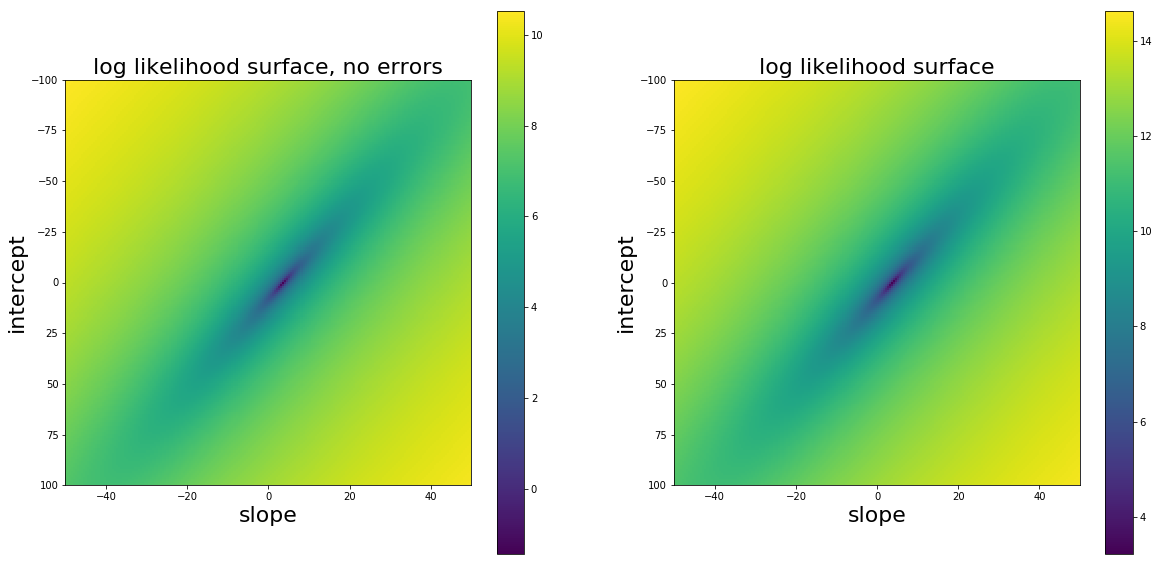

In [97]:
resids_noerror = np.array(resids_noerror).reshape(np.sqrt(len(resids)), np.sqrt(len(resids)))
resids = np.array(resids).reshape(np.sqrt(len(resids)), np.sqrt(len(resids)))
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: This plot shows how the log_likelihood varies with the vary of slope and interception. The more purplr means low value of log_likelihood, better model; and the more yellow means higher value of log_likelihood, worse model. And we can tell that whtn both the values of slope and interception are near 0 (but cannot be equal to 0), the value of log_likelihood is low.

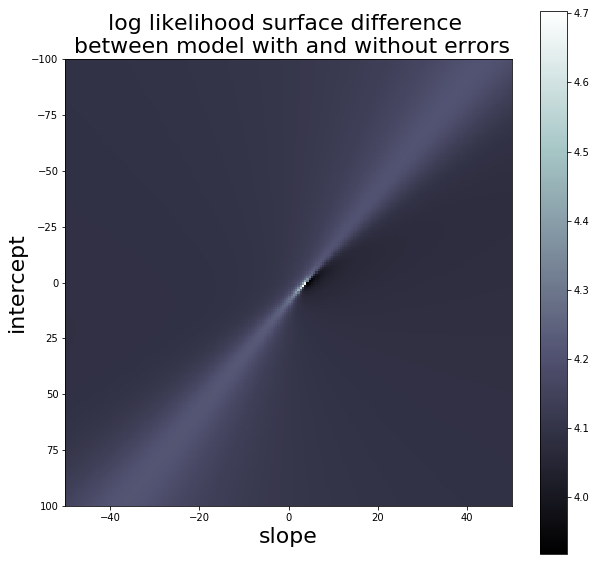

In [98]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: This plot shows the difference between log_likelihood with or without error. According to Figure 11, when the value of log_likelihood is low, the gap becomes significant. Which means the impact of error is significant in those "good" model.

# EXTRA CREDIT: a plot of anything related to these data

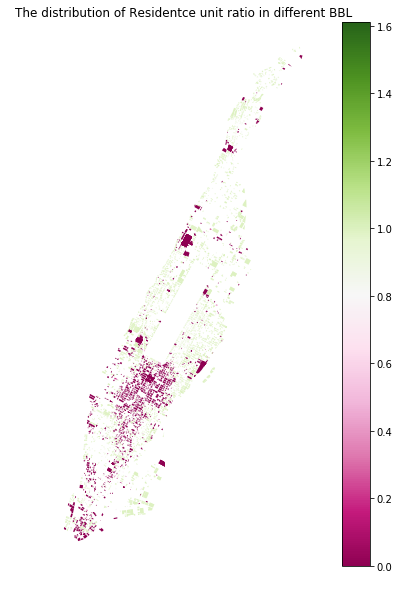

In [99]:
bblnrgdataCut['resratio'] = bblnrgdataCut['UnitsRes'] / bblnrgdataCut['UnitsTotal']
res_plot_data = bblnrgdataGPD.merge(bblnrgdataCut, left_on = 'BBL', right_on = 'BBL', how = 'inner')
res_plot_data.to_crs(epsg=2263).plot(column='resratio', legend=True, figsize=(10,10), cmap='PiYG')
plt.axis('off')
plt.title('The distribution of Residentce unit ratio in different BBL')
plt.show()

Figure 11. This plot shows the distribution of residence unit ratio in different BBL. The more red BBL means the lower ratio of residence unit, the more green BBL means the higher ratio of residence unit. We can tell that, in Manhattan, the BBL below the central park is mainly non-residence unit, and the uptown is mainly residence units.